# JETSCAPE VAH: Bayesian parameter inference for **relativistic heavy ion collisions**

### What's in This Notebook

**1. Physics simulation and preprocessing of the simulation data**

##### Physics model

Simulate relativistic heavy ion collisions for a Latin Hyper Cube design. Load saved simulation data from a folder. Anyone who wish to use the code to do another Bayesian analysis for relativistic heavy ion collision should do minor change to this section that suits    their model and simulation data.

Python modules used

 > pandas

##### Preprocessing and dimensional reduction of the simulation data


We first standardize observables by substracting the mean and scaling it to have unit variance. Then do a Principal Component Analysis (PCA) to reduce the dimensionality of the data. 

Python modules used

 > numpy
 
 > sklearn
             
**2. Load validation and experimental data**

Relevant data is loaded from disk.
           
Python modules used

 > pandas

**3. Building Emulators**

Since the simulations are computationally expensive we need surrogate models that can be trained on a sparse set of simulation data obtained from the full model and are then used to interpolate the model output speedily to any other point in the multi-dimensional parameter space. For this purpose we use Gaussian Processes. They also give the uncertainty in the prediction which is very important to properly account all uncertainties and reliably extract parameters using Bayesian methods. 

Python modules used

 > sklearn
 
 > numpy
                
**4. Bayesian parameter estimation**

The Bayes theorem is used to find the posterior of the model parameters using the emulators and the pseudo experimental data.

Python modules used

> pandas

> numpy

> seaborn

### Import all the necessary libraries that we mention above

In [1]:
import sys
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from numpy.linalg import inv
import sklearn, matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

import uncertainty_toolbox as uct

import ptemcee
import h5py
from scipy.linalg import lapack
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
sns.set("notebook")

### Define some name variables

In [2]:
name="JETSCAPEVAH"
#Saved emulator name
EMU='PbPb2760_vah_emulators.dat'
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Data/"

In [3]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

### Step 1: Physics model.

#### 1. 1: Simulation data. (Pb Pb collisions at 2.76 TeV)

Bayesian inference require millions of simulations. Simulation is computationally expensive! We need to build emulators to replace computationally expensive simulation.

To build emulators we need training data from the simulation. To get training data we simulate Pb Pb collisions at 2.76 TeV for a Latin Hyper Cube design.

In [4]:
# Design points
design = pd.read_csv('sliced_VAH_090321.txt', delimiter = ' ')
design_validation = pd.read_csv('sliced_VAH_090321_test.txt', delimiter = ' ')

In [5]:
design.shape

(500, 16)

In [6]:
design.head()

,Pb_Pb,Mean,Width,Dist,Flactutation,Temp,Kink,eta_s,Slope_low,Slope_high,Max,Temp_peak,Width_peak,Asym_peak,R,tau_initial
0,10.14,0.1638,0.959,0.6035,1.6107,0.16329,0.18457,0.13825,-1.517,-0.769,0.06928,0.24798,0.063125,0.2448,0.3791,0.05
1,10.74,-0.1162,1.169,1.5215,0.6281,0.13563,0.17777,0.13483,-1.529,1.589,0.14752,0.18930,0.106375,-0.6992,0.5961,0.05
2,11.14,-0.0434,1.115,1.5385,0.6791,0.15153,0.14513,0.09227,0.313,-0.271,0.23968,0.21090,0.030125,-0.2320,0.6983,0.05
3,11.22,-0.1610,1.017,1.5827,1.2809,0.14445,0.17165,0.18765,0.709,0.359,0.10624,0.13926,0.114625,0.6832,0.6255,0.05
4,11.70,0.4998,1.383,0.0663,1.6651,0.15705,0.21381,0.07441,-0.197,1.109,0.16096,0.15654,0.082375,-0.7408,0.7711,0.05


In [7]:
#drop tau_initial parameter for now because we keep it fixed
design = design.drop(labels='tau_initial', axis=1)
design_validation = design_validation.drop(labels='tau_initial', axis=1)

In [8]:
# We have only simulated first 150 design points for now
design = design.iloc[0:200]
design_validation = design_validation.iloc[0:50]



In [9]:
design.shape

(200, 15)

In [10]:
design.head()

,Pb_Pb,Mean,Width,Dist,Flactutation,Temp,Kink,eta_s,Slope_low,Slope_high,Max,Temp_peak,Width_peak,Asym_peak,R
0,10.14,0.1638,0.959,0.6035,1.6107,0.16329,0.18457,0.13825,-1.517,-0.769,0.06928,0.24798,0.063125,0.2448,0.3791
1,10.74,-0.1162,1.169,1.5215,0.6281,0.13563,0.17777,0.13483,-1.529,1.589,0.14752,0.18930,0.106375,-0.6992,0.5961
2,11.14,-0.0434,1.115,1.5385,0.6791,0.15153,0.14513,0.09227,0.313,-0.271,0.23968,0.21090,0.030125,-0.2320,0.6983
3,11.22,-0.1610,1.017,1.5827,1.2809,0.14445,0.17165,0.18765,0.709,0.359,0.10624,0.13926,0.114625,0.6832,0.6255
4,11.70,0.4998,1.383,0.0663,1.6651,0.15705,0.21381,0.07441,-0.197,1.109,0.16096,0.15654,0.082375,-0.7408,0.7711


In [11]:
design_validation.shape

(50, 15)

In [12]:
design_validation.shape

(50, 15)

Run the simulation for these design points and calculate the observables!

In [13]:
#### Block 5 #### Please refer to this number in your questions

#Simulation outputs at the design points
simulation = pd.read_csv(filepath_or_buffer="mean_for_200_sliced_200_events_design", index_col=0)
simulation_sd = pd.read_csv(filepath_or_buffer="sd_for_200_sliced_200_events_design", index_col=0)

In [14]:
# Load testing data

validation = pd.read_csv(filepath_or_buffer="mean_for_50_sliced_200_events_test_design", index_col=0)
validation_sd = pd.read_csv(filepath_or_buffer="sd_for_50_sliced_200_events_test_design", index_col=0)

In [15]:
# Load experimental data
experiment=pd.read_csv(filepath_or_buffer="PbPb2760_experiment",index_col=0)



In [16]:
# Gather what type of experimental data do we have. 
exp_label=[]
for i in experiment.columns:
    words=i.split('[')
    exp_label.append(words[0]+'_['+words[1])

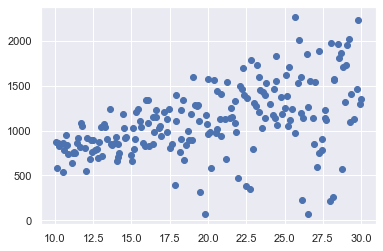

In [17]:
#simple test to see how particle yields change with the Normalization
plt.scatter(design.values[:,0],simulation.values[:,0])

In [18]:
# Only keep simulation data that we have corresponding experimental data
simulation=simulation[exp_label]
simulation_sd=simulation_sd[exp_label]

validation = validation[exp_label]
validation_sd = validation_sd[exp_label]

In [19]:
simulation.head()

,dNch_deta_[0 5],dNch_deta_[ 5 10],dNch_deta_[10 20],dNch_deta_[20 30],dNch_deta_[30 40],dNch_deta_[40 50],dNch_deta_[50 60],dNch_deta_[60 70],dET_deta_[0. 2.5],dET_deta_[2.5 5. ],...,v32_[10 20],v32_[20 30],v32_[30 40],v32_[40 50],v42_[0 5],v42_[ 5 10],v42_[10 20],v42_[20 30],v42_[30 40],v42_[40 50]
0,587.718307,488.368426,409.926322,271.544779,190.017365,113.214814,65.907212,33.686893,653.239188,590.265615,...,0.009930,0.012067,0.010669,0.010094,-0.001980,0.002404,0.003078,0.004522,-0.003273,-0.002880
1,947.292892,782.914215,568.784680,384.763598,241.774478,139.951574,83.310923,54.353873,1196.857327,1078.048448,...,0.012746,0.013495,0.015370,0.014050,0.003251,0.006586,0.007000,0.007409,0.008185,0.007237
2,635.934869,477.182845,391.057512,282.102205,191.055334,118.445838,70.250559,43.672274,715.894012,599.666105,...,0.012971,0.017742,0.015577,0.010069,0.001135,0.005803,0.005317,0.005474,0.005978,0.005471
3,767.308846,608.086572,456.022406,298.081937,197.950190,110.299162,58.789993,30.005399,1061.963354,914.088348,...,0.017902,0.015917,0.017005,0.010849,0.005237,0.008047,0.010046,0.009778,0.006547,0.006010
4,1091.101617,875.524452,629.876067,395.329686,264.541202,176.060030,95.621539,48.921931,1274.519829,1182.880954,...,0.017615,0.020023,0.014811,0.011744,0.007458,0.006895,0.007447,0.005461,0.004357,0.004619


### After talking with Matt we decided to get rid of observables that are too difficult to calculate for now and do dimensional reduction, emulator building and calibration with observables that have smaller statistical variance.


#### We will not consider PT fluctuations and flow coefficients for now, and proceed with other observables.

In [20]:
exp_label[-32]

'pT_fluct_[0 5]'

In [21]:
selected_observables = exp_label[0:-32]
print(f'Last item on the selected observable is {selected_observables[-1]}')

Last item on the selected observable is mean_pT_proton_[60 70]


In [22]:
simulation=simulation[selected_observables]
simulation_sd=simulation_sd[selected_observables]
print(f'Shape of the constrained simulation output {simulation.shape}')

Shape of the constrained simulation output (200, 78)


In [23]:
validation=validation[selected_observables]
validation_sd=validation_sd[selected_observables]
print(f'Shape of the constrained simulation output {validation.shape}')

Shape of the constrained simulation output (50, 78)


# REMOVE BAD DESIGNS

In [24]:
drop_index= np.array([19, 23, 31, 32, 71, 91, 92, 98, 129, 131, 146, 162, 171, 174, 184, 190, 194, 195, 198])
drop_index_vl= np.array([29, 35, ])

In [25]:
design=design.drop(index=drop_index)


In [26]:
design_validation=design_validation.drop(index=drop_index_vl)



In [27]:
design.head()

,Pb_Pb,Mean,Width,Dist,Flactutation,Temp,Kink,eta_s,Slope_low,Slope_high,Max,Temp_peak,Width_peak,Asym_peak,R
0,10.14,0.1638,0.959,0.6035,1.6107,0.16329,0.18457,0.13825,-1.517,-0.769,0.06928,0.24798,0.063125,0.2448,0.3791
1,10.74,-0.1162,1.169,1.5215,0.6281,0.13563,0.17777,0.13483,-1.529,1.589,0.14752,0.18930,0.106375,-0.6992,0.5961
2,11.14,-0.0434,1.115,1.5385,0.6791,0.15153,0.14513,0.09227,0.313,-0.271,0.23968,0.21090,0.030125,-0.2320,0.6983
3,11.22,-0.1610,1.017,1.5827,1.2809,0.14445,0.17165,0.18765,0.709,0.359,0.10624,0.13926,0.114625,0.6832,0.6255
4,11.70,0.4998,1.383,0.0663,1.6651,0.15705,0.21381,0.07441,-0.197,1.109,0.16096,0.15654,0.082375,-0.7408,0.7711


In [28]:
simulation=simulation.drop(index=drop_index)

In [29]:
validation=validation.drop(index=drop_index_vl)

In [30]:
simulation_sd=simulation_sd.drop(index=drop_index)

In [31]:
validation_sd=validation_sd.drop(index=drop_index_vl)

In [32]:
simulation_sd.shape

(181, 78)

In [33]:
simulation_sd.shape

(181, 78)

In [34]:
X = design.values
Y = simulation.values

print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (181, 15)
Y.shape : (181, 78)


In [35]:
design.head()

,Pb_Pb,Mean,Width,Dist,Flactutation,Temp,Kink,eta_s,Slope_low,Slope_high,Max,Temp_peak,Width_peak,Asym_peak,R
0,10.14,0.1638,0.959,0.6035,1.6107,0.16329,0.18457,0.13825,-1.517,-0.769,0.06928,0.24798,0.063125,0.2448,0.3791
1,10.74,-0.1162,1.169,1.5215,0.6281,0.13563,0.17777,0.13483,-1.529,1.589,0.14752,0.18930,0.106375,-0.6992,0.5961
2,11.14,-0.0434,1.115,1.5385,0.6791,0.15153,0.14513,0.09227,0.313,-0.271,0.23968,0.21090,0.030125,-0.2320,0.6983
3,11.22,-0.1610,1.017,1.5827,1.2809,0.14445,0.17165,0.18765,0.709,0.359,0.10624,0.13926,0.114625,0.6832,0.6255
4,11.70,0.4998,1.383,0.0663,1.6651,0.15705,0.21381,0.07441,-0.197,1.109,0.16096,0.15654,0.082375,-0.7408,0.7711


In [36]:
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\sigma_k$',
 '$T_{\\mathrm{sw}}$ [GeV]',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$R$']

#### <center> We have load the simulation data from our LHS design!

#### 1.3: Preprocessing and dimensional reduction of the simulation data.

###### Our emulators can train only one observable at a time. Training  emulators for each observable is difficult! We use PCA to reduce dimensionality of our data.

 More details about Singular Value Decomposition (SVD) and Principal Component Analysis (PCA)can be found here.
[Web article](https://intoli.com/blog/pca-and-svd/)

In [37]:
#Scaling the data to be zero mean and unit variance for each observables
SS  =  StandardScaler(copy=True)
#Singular Value Decomposition
u, s, vh = np.linalg.svd(SS.fit_transform(Y), full_matrices=True)
print(f'shape of u {u.shape} shape of s {s.shape} shape of vh {vh.shape}')

shape of u (181, 181) shape of s (78,) shape of vh (78, 78)


##### How many PCs to keep?

/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


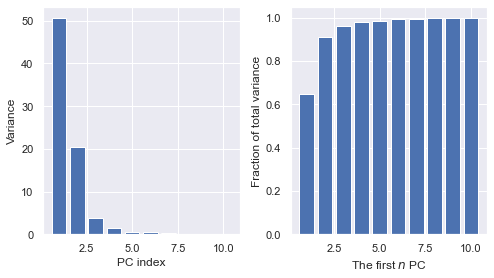

In [38]:
#### Block 8 #### Please refer to this number in your questions
npc = 10
# print the explained raito of variance
# https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,4))
#importance = pca_analysis.explained_variance_
importance = np.square(s[:npc]/math.sqrt(u.shape[0]-1))
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance)
ax1.set_xlabel("PC index")
ax1.set_ylabel("Variance")
ax2.bar(idx,cumulateive_importance)
ax2.set_xlabel(r"The first $n$ PC")
ax2.set_ylabel("Fraction of total variance")
plt.tight_layout(True)

In [39]:
#### Block 9 #### Please refer to this number in your questions
#whiten and project data to principal component axis (only keeping first 10 PCs)
pc_tf_data=u[:,0:npc] * math.sqrt(u.shape[0]-1)
print(f'Shape of PC transformed data {pc_tf_data.shape}')
#Scale Transformation from PC space to original data space
inverse_tf_matrix= np.diag(s[0:npc]) @ vh[0:npc,:] * SS.scale_.reshape(1,-1)/ math.sqrt(u.shape[0]-1)

Shape of PC transformed data (181, 10)


In [40]:
# save the invese tf matrix to be loaded from streamlit
np.save('INV_MAT',inverse_tf_matrix)
np.save('SS_MN',SS.mean_)

new_model_input => Predictions from emulators => predictions in the PC space (10) => Apply inverse transformation => Observables space (110)

#### <center> We have reduced the dimension of observables to 10 for simulation training data.

#### <center> Now we can train 10 emulators to replace the computationally expensive simulation. (Step 3)

    
#### <center> We have an inverse transformation matrix to go back from 10 dimension to observable space dimensions.

### Step 2: Load validation and experimental data.

Validation data is also generated using a LHS design!

In [41]:
#### Block 11 #### Please refer to this number in your questions


# We will use the first data point in our validation set as the pseudo experimental data

#validation_design = pd.read_csv(filepath_or_buffer=data_path("PbPb2760_validation_design"))
#validation_simulation = pd.read_csv(filepath_or_buffer=data_path("PbPb2760_validation_simulation"))
#validation_simulation_sd = pd.read_csv(filepath_or_buffer=data_path("PbPb2760_validation_simulation_error"))



In [42]:
#print(f'Validation data design points have the shape {validation_design.shape} and validation simulation outputs have the shape {validation_simulation.shape}')

In [43]:
#validation_design.head()

In [44]:
#validation_simulation.head()

In [45]:
#validation_simulation_sd.head()

In [46]:
# Make predicttions from trained emulators for validation data


#### What can we use the validation data set for?
1. To validate the emulators we will be building in the next section 
2. To validate the Bayesian workflow

In [47]:
#### Block 12 #### Please refer to this number in your questions

#This is how you can load the actual experimental data instead of pseudo experimental data
experiment=pd.read_csv(filepath_or_buffer="PbPb2760_experiment",index_col=0)
experiment.head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
mean,1601.0,1294.0,966.0,649.0,426.0,261.0,149.0,76.0,1803.0,1647.0,...,0.026220,0.028840,0.030310,0.030220,9.720000e-03,1.133000e-02,1.250000e-02,1.390000e-02,1.540000e-02,0.015140
variance,3600.0,2401.0,1369.0,529.0,225.0,81.0,36.0,16.0,11981.0,9882.0,...,0.000001,0.000001,0.000002,0.000002,2.362000e-07,4.234000e-07,3.229000e-07,5.345000e-07,7.093000e-07,0.000001


In this notebook we take a simulation output for a known set of input parameters as the pseudo experimental data and then do a Bayesian parameter estimation.  We leave it as an exercise for you to use the real experimental data to perform a Bayesian parameter inference.

Let's take the first simulation data point from validation set to be pseudo experimental data.

In [48]:
experiment.values.shape

(2, 110)

In [49]:
#### Block 13 #### Please refer to this number in your questions


y_exp= experiment.values[0,0:-32]
y_exp_variance= experiment.values[1,0:-32]
print(f'Shape of the experiment observables {y_exp.shape} and shape of the experimental error variance{y_exp_variance.shape}')

Shape of the experiment observables (78,) and shape of the experimental error variance(78,)


In [50]:
# Save these experimental data for later use by streamlit

#### 2.1: Plot the experimental data

The following 5 cells are used to generate a beautiful plot for the experimental data. Don't worry about them too much! 

In [51]:
#### Block 14 #### Please refer to this number in your questions


from collections import OrderedDict

colors = OrderedDict([
    ('blue', '#4e79a7'),
    ('orange', '#f28e2b'),
    ('green', '#59a14f'),
    ('red', '#e15759'),
    ('cyan', '#76b7b2'),
    ('purple', '#b07aa1'),
    ('brown', '#9c755f'),
    ('yellow', '#edc948'),
    ('pink', '#ff9da7'),
    ('gray', '#bab0ac')
])

fontsize = dict(
    large=11,
    normal=10,
    small=9,
    tiny=8
)

offblack = '.15'

plt.rcdefaults()
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Lato'],
    'mathtext.fontset': 'custom',
    'mathtext.default': 'it',
    'mathtext.rm': 'sans',
    'mathtext.it': 'sans:italic:medium',
    'mathtext.cal': 'sans',
    'font.size': fontsize['normal'],
    'legend.fontsize': fontsize['normal'],
    'axes.labelsize': fontsize['normal'],
    'axes.titlesize': fontsize['large'],
    'xtick.labelsize': fontsize['small'],
    'ytick.labelsize': fontsize['small'],
    #'font.weight': 400,
    'axes.labelweight': 400,
    'axes.titleweight': 400,
    'axes.prop_cycle': plt.cycler('color', list(colors.values())),
    'lines.linewidth': .8,
    'lines.markersize': 3,
    'lines.markeredgewidth': 0,
    'patch.linewidth': .8,
    'axes.linewidth': .6,
    'xtick.major.width': .6,
    'ytick.major.width': .6,
    'xtick.minor.width': .4,
    'ytick.minor.width': .4,
    'xtick.major.size': 3.,
    'ytick.major.size': 3.,
    'xtick.minor.size': 2.,
    'ytick.minor.size': 2.,
    'xtick.major.pad': 3.5,
    'ytick.major.pad': 3.5,
    'axes.labelpad': 4.,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'text.color': offblack,
    'axes.edgecolor': offblack,
    'axes.labelcolor': offblack,
    'xtick.color': offblack,
    'ytick.color': offblack,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})

def set_tight(fig=None, **kwargs):
    """
    Set tight_layout with a better default pad.

    """
    if fig is None:
        fig = plt.gcf()

    kwargs.setdefault('pad', .1)
    fig.set_tight_layout(kwargs)

In [52]:
#### Block 15 #### Please refer to this number in your questions


# 8 bins
ALICE_cent_bins = np.array([[0,5],[5,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70]]) 

obs_cent_list = {
'Pb-Pb-2760': {
    'dNch_deta' : ALICE_cent_bins,
    'dET_deta' : np.array([[0, 2.5], [2.5, 5], [5, 7.5], [7.5, 10],
                           [10, 12.5], [12.5, 15], [15, 17.5], [17.5, 20],
                           [20, 22.5], [22.5, 25], [25, 27.5], [27.5, 30],
                           [30, 32.5], [32.5, 35], [35, 37.5], [37.5, 40],
                           [40, 45], [45, 50], [50, 55], [55, 60],
                           [60, 65], [65, 70]]), # 22 bins
    'dN_dy_pion'   : ALICE_cent_bins,
    'dN_dy_kaon'   : ALICE_cent_bins,
    'dN_dy_proton' : ALICE_cent_bins,
    'dN_dy_Lambda' : np.array([[0,5],[5,10],[10,20],[20,40],[40,60]]), # 5 bins
    'dN_dy_Omega'  : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'dN_dy_Xi'     : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'mean_pT_pion'   : ALICE_cent_bins,
    'mean_pT_kaon'   : ALICE_cent_bins,
    'mean_pT_proton' : ALICE_cent_bins,
    'pT_fluct' : np.array([[0,5],[5,10],[10,15],[15,20], [20,25],[25,30],[30,35],[35,40], [40,45],[45,50],[50,55],[55,60]]), #12 bins
    'v22' : ALICE_cent_bins,
    'v32' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    'v42' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    }
}

In [53]:
#### Block 16 #### Please refer to this number in your questions


obs_groups = {'yields' : ['dNch_deta', 'dET_deta', 'dN_dy_pion', 'dN_dy_kaon', 'dN_dy_proton'],
              'mean_pT' : ['mean_pT_pion', 'mean_pT_kaon','mean_pT_proton', ]}

obs_group_labels = {'yields' : r'$dN_\mathrm{id}/dy_p$, $dN_\mathrm{ch}/d\eta$, $dE_T/d\eta$ [GeV]',
                    'mean_pT' : r'$ \langle p_T \rangle_\mathrm{id}$' + ' [GeV]',
                    'fluct' : r'$\delta p_{T,\mathrm{ch}} / \langle p_T \rangle_\mathrm{ch}$',
                    'flows' : r'$v^{(\mathrm{ch})}_k\{2\} $'}

colors = ['b', 'g', 'r', 'c', 'm', 'tan', 'gray']

obs_tex_labels = {'dNch_deta' : r'$dN_\mathrm{ch}/d\eta$' + ' x 2',
                  'dN_dy_pion' : r'$dN_{\pi}/dy_p$',
                  'dN_dy_kaon' : r'$dN_{K}/dy_p$',
                  'dN_dy_proton' : r'$dN_{p}/dy_p$',
                  'dET_deta' : r'$dE_{T}/d\eta$' + ' x 5',
                  
                  'mean_pT_proton' : r'$\langle p_T \rangle_p$',
                  'mean_pT_kaon' : r'$\langle p_T \rangle_K$',
                  'mean_pT_pion' : r'$\langle p_T \rangle_\pi$',
                 
                  'pT_fluct' : None,
                  'v22' : r'$v^{(\mathrm{ch})}_2\{2\}$',
                  'v32' : r'$v^{(\mathrm{ch})}_3\{2\}$',
                  'v42' : r'$v^{(\mathrm{ch})}_4\{2\}$'}

In [54]:
#### Block 17 #### Please refer to this number in your questions


index={}
st_index=0
for obs_group in  obs_groups.keys():
    for obs in obs_groups[obs_group]:
        #print(obs)
        n_centrality= len(obs_cent_list['Pb-Pb-2760'][obs])
        #print(n_centrality)
        index[obs]=[st_index,st_index+n_centrality]
        st_index = st_index+n_centrality
print(index)

{'dNch_deta': [0, 8], 'dET_deta': [8, 30], 'dN_dy_pion': [30, 38], 'dN_dy_kaon': [38, 46], 'dN_dy_proton': [46, 54], 'mean_pT_pion': [54, 62], 'mean_pT_kaon': [62, 70], 'mean_pT_proton': [70, 78]}


/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Done


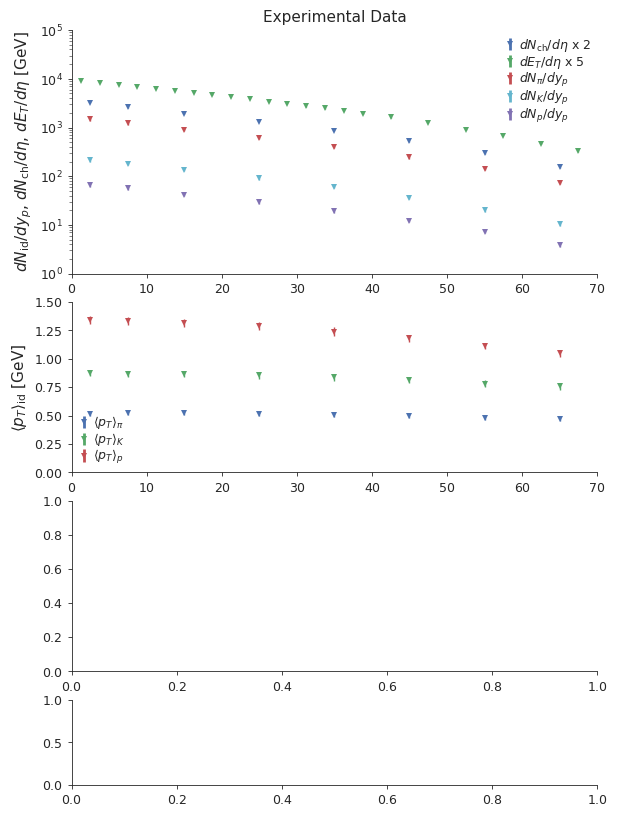

In [55]:
#### Block 18 #### Please refer to this number in your questions


# height_ratios = [1.8, 1.2, 1.5, 1.]
height_ratios = [2, 1.4, 1.4, 0.7]
column = 1
fig, axes = plt.subplots(nrows=4, ncols=column, figsize=(6, 8), squeeze=False, 
                         gridspec_kw={'height_ratios': height_ratios})

for row, obs_group in enumerate(obs_groups.keys()):
    for obs, color in zip(obs_groups[obs_group], colors):
        expt_label = 'ALICE'
        
        axes[row][0].tick_params(labelsize=9)
       # axes[row][1].tick_params(labelsize=9)
        
        scale = 1.0
        
        if obs_group == 'yields':
            axes[row][0].set_yscale('log')
          #  axes[row][1].set_yscale('log')
            
            axes[row][0].set_title("Experimental Data", fontsize = 11)
          #  axes[row][1].set_title("VAH + PTMA", fontsize = 11)
           
            if obs == 'dET_deta':
                scale = 5.
            if obs == 'dNch_deta':
                scale = 2.
        
        axes[row][0].set_ylabel(obs_group_labels[obs_group], fontsize = 11)
        
        xbins = np.array(obs_cent_list['Pb-Pb-2760'][obs])
        x = (xbins[:,0] + xbins[:,1]) / 2.

        #Y1 = Ymodel1['Pb-Pb-2760'][obs]['mean'][0][0]
        #Yerr1 = Ymodel1['Pb-Pb-2760'][obs]['err'][0][0]
        
        #Y2 = Ymodel2['Pb-Pb-2760'][obs]['mean'][0][0]
        #Yerr2 = Ymodel2['Pb-Pb-2760'][obs]['err'][0][0]
        
        label = obs_tex_labels[obs]
            
       # axes[row][0].plot(x, Y1*scale, color = color, label = label, lw = 1.5)
       # axes[row][0].fill_between(x, (Y1-Yerr1)*scale, (Y1+Yerr1)*scale, color=color, alpha=0.2)
        
       # axes[row][1].plot(x, Y2*scale, color = color, label = label, lw = 1.5)
       # axes[row][1].fill_between(x, (Y2-Yerr2)*scale, (Y2+Yerr2)*scale, color=color, alpha=0.2)
        
        exp_mean = y_exp[index[obs][0]:index[obs][1]]
        exp_err = np.sqrt(y_exp_variance[index[obs][0]:index[obs][1]])
        #exp_mean = Yexp['Pb-Pb-2760'][obs]['mean'][0]
        #exp_err = Yexp['Pb-Pb-2760'][obs]['err'][0]
    
        axes[row][0].errorbar(x, exp_mean*scale, exp_err, color=color, fmt='v', markersize='4', elinewidth=1, label=label)
        #axes[row][1].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
            

        
    leg = axes[row][0].legend(fontsize=9, borderpad=0, labelspacing=0, handlelength=1, handletextpad=0.2)
    
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        legobj.set_alpha(1.0)

    axes[row][0].set_xlim(0, 70)

    if obs_group == 'yields':
        axes[row][0].set_ylim(1, 1e5)
       # axes[row][1].set_ylim(1, 1e4)
    if obs_group == 'mean_pT':
        axes[row][0].set_ylim(0., 1.5)
       # axes[row][1].set_ylim(0., 1.5)
    if obs_group == 'fluct':
        axes[row][0].set_ylim(0.0, 0.06)
      #  axes[row][1].set_ylim(0.0, 0.04)
    if obs_group == 'flows':
        axes[row][0].set_ylim(0.0, 0.15)
       # axes[row][1].set_ylim(0.0, 0.12)
    if axes[row][0].is_last_row():
        axes[row][0].set_xlabel('Centrality %', fontsize = 11)
       # axes[row][1].set_xlabel('Centrality %', fontsize = 11)
        
plt.tight_layout(True)
# set_tight(fig, rect=[0, 0, 1, 0.95])
set_tight(fig, rect=[0, 0, 1, 1])
save_fig("Experimental_data.png")

print("Done")




### Step 3: Building emulators

#### We train emulators for each of the Principal Components that we keep. (10 in total) 

Since the simulations are computationally expensive we need surrogate models that can be trained on a sparse set of simulation data obtained from the full model and are then used to interpolate the model output speedily to any other point in the 17-dimensional parameter space.

Our emulators are Gaussian Process emulators with RBF kernel and an additive white noise. A good introduction to Gaussian Process emulators can be found [here](https://distill.pub/2019/visual-exploration-gaussian-processes/).

> Weiyao's hands-on [session](https://github.com/JETSCAPE/SummerSchool2021/blob/master/Jul28_29_BayesianSoftExample/SimpleGaussianProcess.ipynb) 


In [56]:
model_param = design.columns
prior_min = [10, -0.7, 0.5, 0, 0.3, 0.135, 0.13, 0.01, -2, -1, 0.01, 0.12, 0.025, -0.8, 0.3]
prior_max = [30, 0.7, 1.5, 1.7, 2, 0.165, 0.3, 0.2, 1, 2, 0.25, 0.3, 0.15, 0.8, 1]

In [57]:
prior_df = pd.DataFrame(data=np.vstack((prior_min,prior_max)),columns=model_param, index = ['min','max'])
prior_df.to_csv(data_path('priorVAH.csv'))

In [58]:
#### Block 10 #### Please refer to this number in your questions

# Bounds for parametrs in the emulator are same as prior ranges so

#prior_df = pd.read_csv(filepath_or_buffer="\Data\priorVAH.csv", index_col=0)

In [59]:
prior_df.head()

,Pb_Pb,Mean,Width,Dist,Flactutation,Temp,Kink,eta_s,Slope_low,Slope_high,Max,Temp_peak,Width_peak,Asym_peak,R
min,10.0,-0.7,0.5,0.0,0.3,0.135,0.13,0.01,-2.0,-1.0,0.01,0.12,0.025,-0.8,0.3
max,30.0,0.7,1.5,1.7,2.0,0.165,0.30,0.20,1.0,2.0,0.25,0.30,0.150,0.8,1.0


In [60]:
design_max=prior_df.loc['max'].values
design_min=prior_df.loc['min'].values

In [61]:
#### Block 19 #### Please refer to this number in your questions

# If false, uses pre-trained emulators.
# If true, retrain emulators.
train_emulators = True
import time
design=X
input_dim=len(design_max)
ptp = design_max - design_min
bound=zip(design_min,design_max)
if (os.path.exists(data_path(EMU))) and (train_emulators==False):
    print('Saved emulators exists and overide is prohibited')
    with open(data_path(EMU),"rb") as f:
        Emulators=pickle.load(f)
else:
    Emulators=[]
    for i in range(0,npc):
        start_time = time.time()
        kernel=1*krnl.RBF(length_scale=ptp,length_scale_bounds=np.outer(ptp, (1e-3, 1e3)))+ krnl.WhiteKernel(noise_level=.1, noise_level_bounds=(1e-3, 1e1))
        GPR=gpr(kernel=kernel,n_restarts_optimizer=100,alpha=0.0000000001)
        GPR.fit(design,pc_tf_data[:,i].reshape(-1,1))
        print(GPR.kernel_)
        print(f'GPR score is {GPR.score(design,pc_tf_data[:,i])} \n')
        #print(f'GPR log_marginal likelihood {GPR.log_marginal_likelihood()} \n')
        print("--- %s seconds ---" % (time.time() - start_time))
        Emulators.append(GPR)

if (train_emulators==True) or not(os.path.exists(data_path(EMU))):
    with open(data_path(EMU),"wb") as f:
        pickle.dump(Emulators,f)

2.61**2 * RBF(length_scale=[33.2, 3.33, 1e+03, 18.7, 22.9, 30, 0.672, 0.881, 78.6, 3.95, 170, 8.33, 125, 939, 38.4]) + WhiteKernel(noise_level=0.237)
GPR score is 0.7821149768251486 

--- 24.261943101882935 seconds ---
1.4**2 * RBF(length_scale=[29.9, 2.73, 0.809, 14, 11.2, 0.0588, 0.493, 0.457, 30.8, 2.07, 0.253, 0.449, 0.144, 1.39, 1.49]) + WhiteKernel(noise_level=0.0182)
GPR score is 0.995901194907271 

--- 26.343157052993774 seconds ---
0.87**2 * RBF(length_scale=[24.3, 0.306, 0.478, 3.38, 1.7, 0.0624, 170, 0.18, 362, 1.45, 40.6, 180, 125, 4.65, 1.8]) + WhiteKernel(noise_level=0.259)
GPR score is 0.834021422074535 

--- 23.409833908081055 seconds ---
1.31**2 * RBF(length_scale=[35.4, 1.2, 1.14, 1.7e+03, 7.15, 0.0426, 170, 0.441, 10.4, 1.64, 0.168, 0.319, 0.136, 2.45, 1.59]) + WhiteKernel(noise_level=0.156)
GPR score is 0.9160960328023618 

--- 17.74234437942505 seconds ---
1.01**2 * RBF(length_scale=[5.05, 0.939, 23, 2.63, 1.7e+03, 29.9, 170, 0.0947, 0.492, 1.66e+03, 0.0474, 0.0179

In [62]:
#### Block 20 #### Please refer to this number in your questions


def predict_observables(model_parameters):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values. Should be an 1D array of 15 model parametrs.
    
    Return
    ----------
    Mean value and full error covaraiance matrix of the prediction is returened. """
    
    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    
    if len(theta)!=15:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,15)
        for i in range(0,npc):
            mn,std=Emulators[i].predict(theta,return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean=mean @ inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)
    variance_matrix=np.diag(np.array(variance).flatten())
    A_p=inverse_tf_matrix
    inverse_transformed_variance=np.einsum('ik,kl,lj-> ij', A_p.T, variance_matrix, A_p, optimize=False)
    return inverse_transformed_mean, inverse_transformed_variance

In [63]:
#make predictions for validation daa from trained emulators
prediction_val = []
prediction_sig_val = []
for row in design_validation.values:
    prediction,pred_cov = predict_observables(row)
    prediction_sig_val.append(np.sqrt(np.diagonal(pred_cov)))
    prediction_val.append(prediction)
prediction_val = np.array(prediction_val).reshape(-1,len(selected_observables))
prediction_sig_val = np.array(prediction_sig_val).reshape(-1,len(selected_observables))

In [64]:
#### Block 17 #### Please refer to this number in your questions


index={}
st_index=0
for obs_group in  obs_groups.keys():
    for obs in obs_groups[obs_group]:
        #print(obs)
        n_centrality= len(obs_cent_list['Pb-Pb-2760'][obs])
        #print(n_centrality)
        index[obs]=[st_index,st_index+n_centrality]
        st_index = st_index+n_centrality
print(index)

{'dNch_deta': [0, 8], 'dET_deta': [8, 30], 'dN_dy_pion': [30, 38], 'dN_dy_kaon': [38, 46], 'dN_dy_proton': [46, 54], 'mean_pT_pion': [54, 62], 'mean_pT_kaon': [62, 70], 'mean_pT_proton': [70, 78]}


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


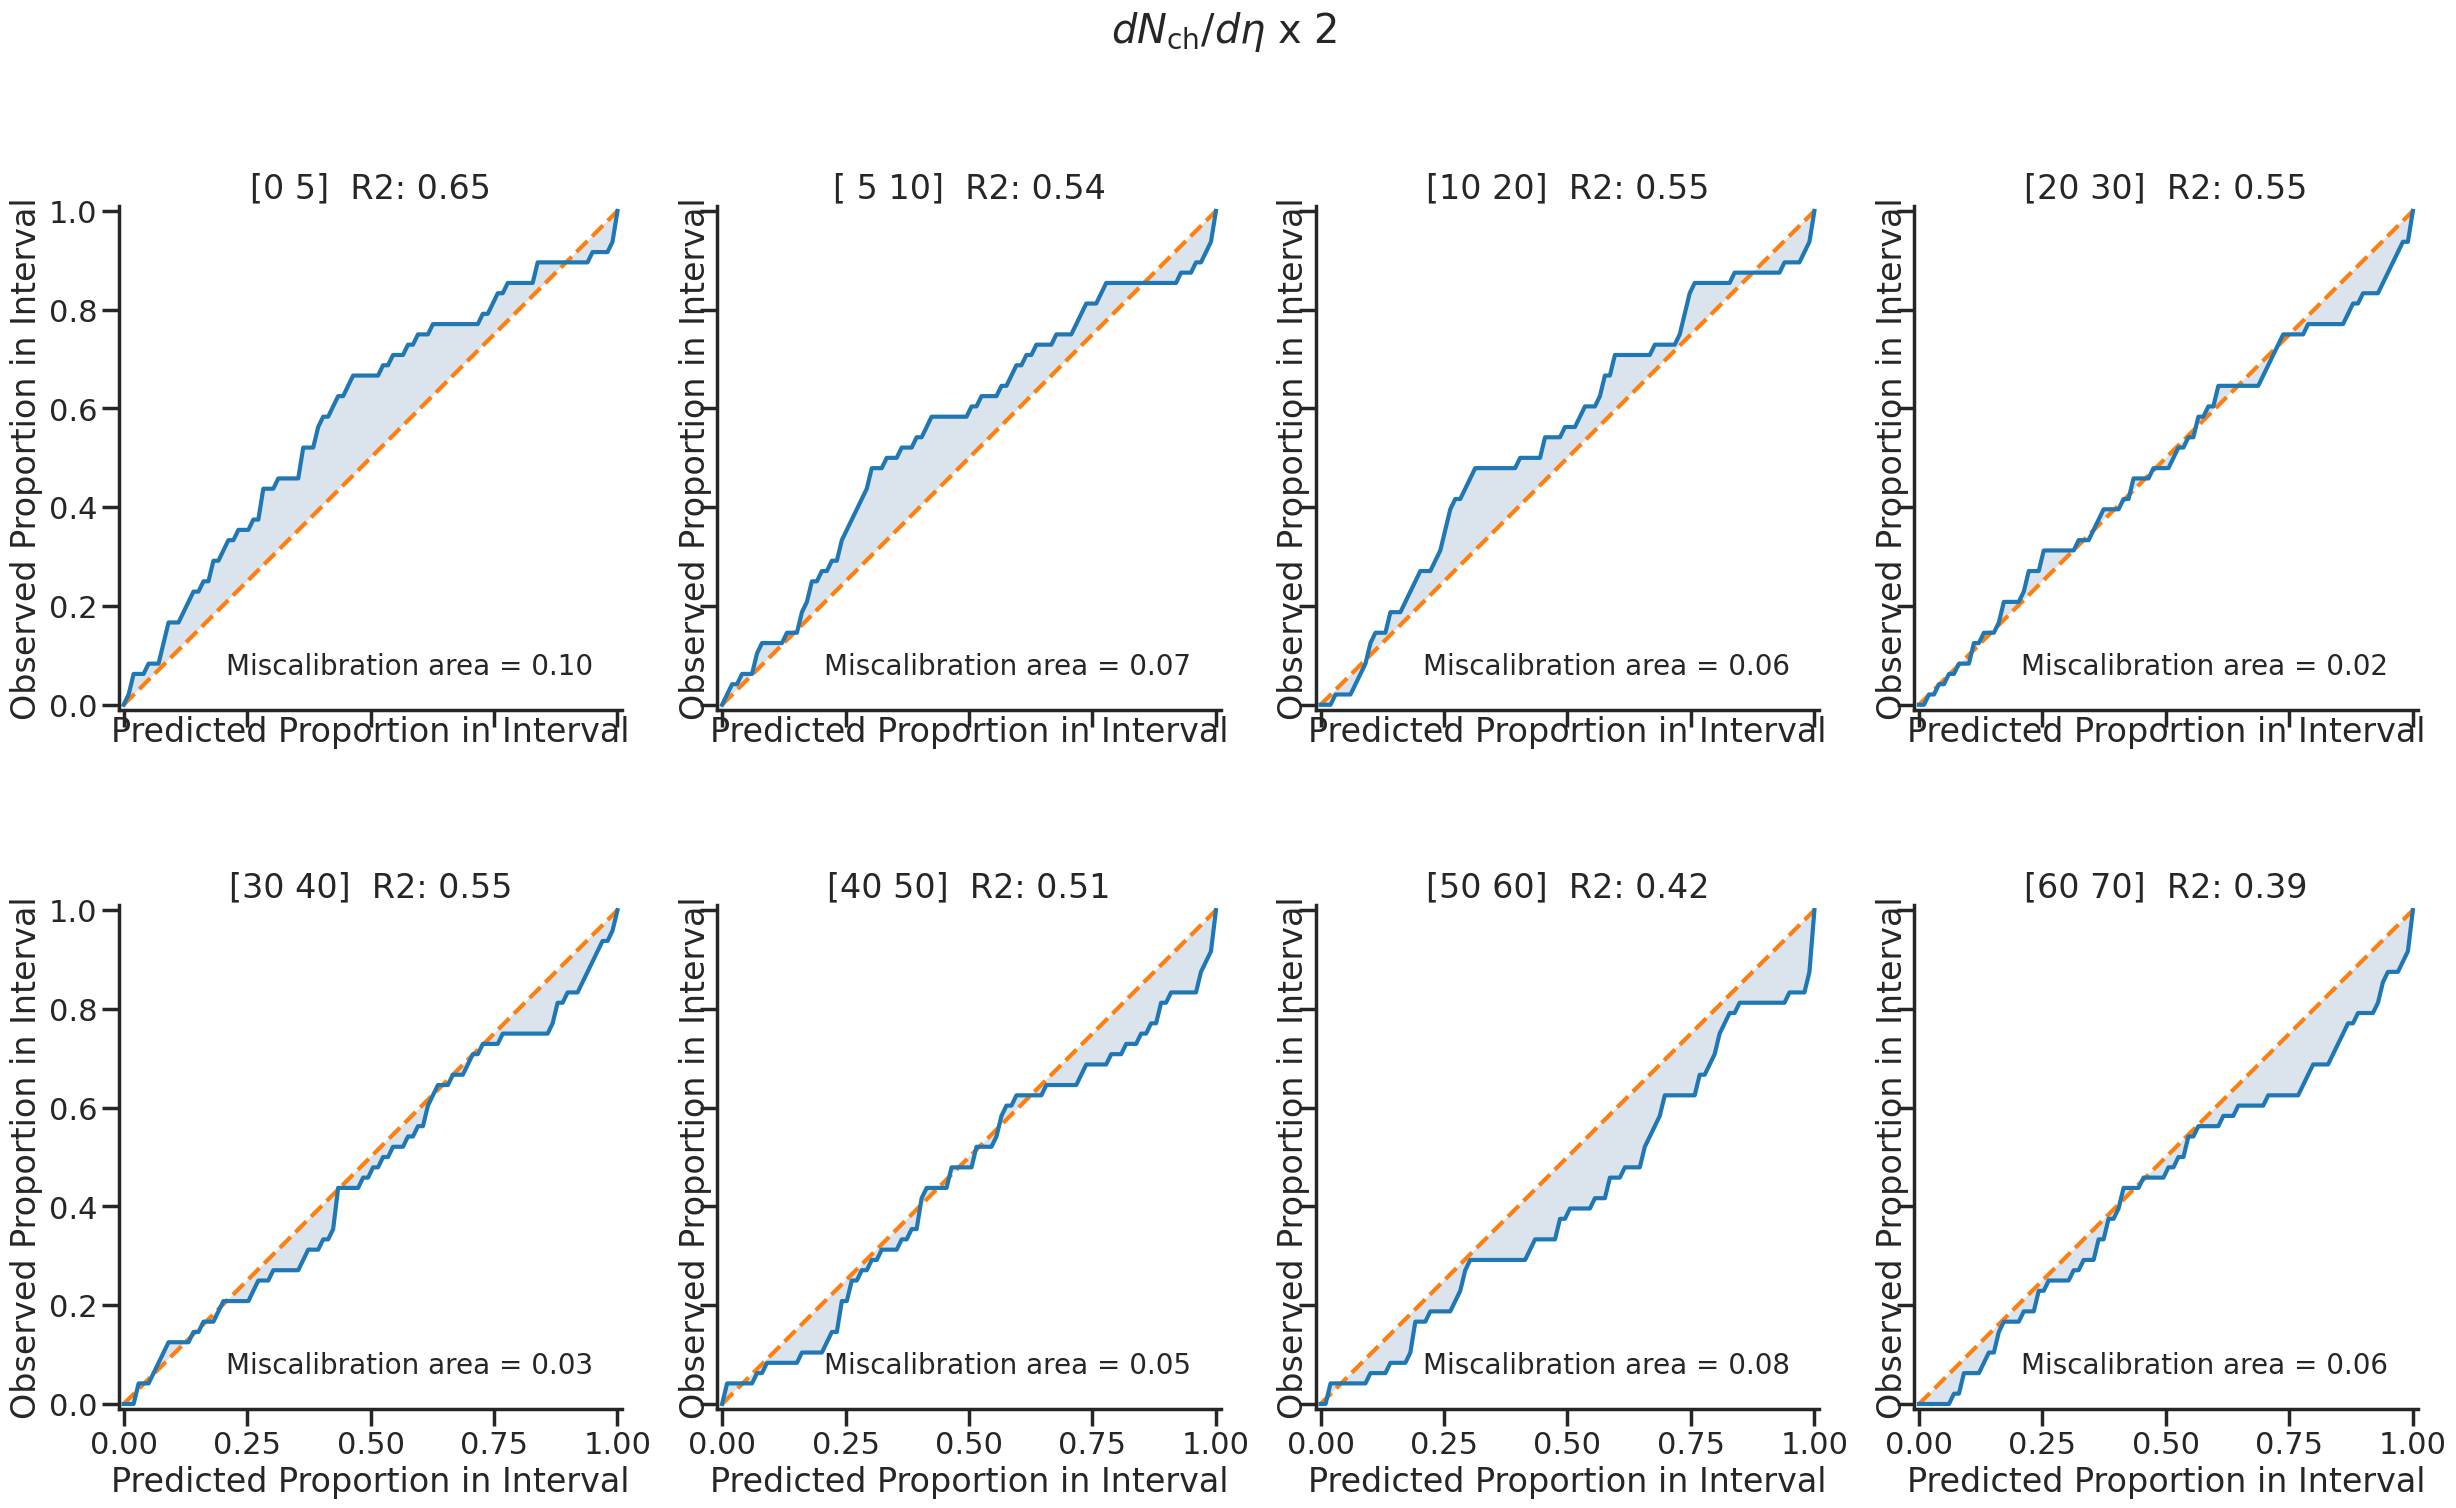

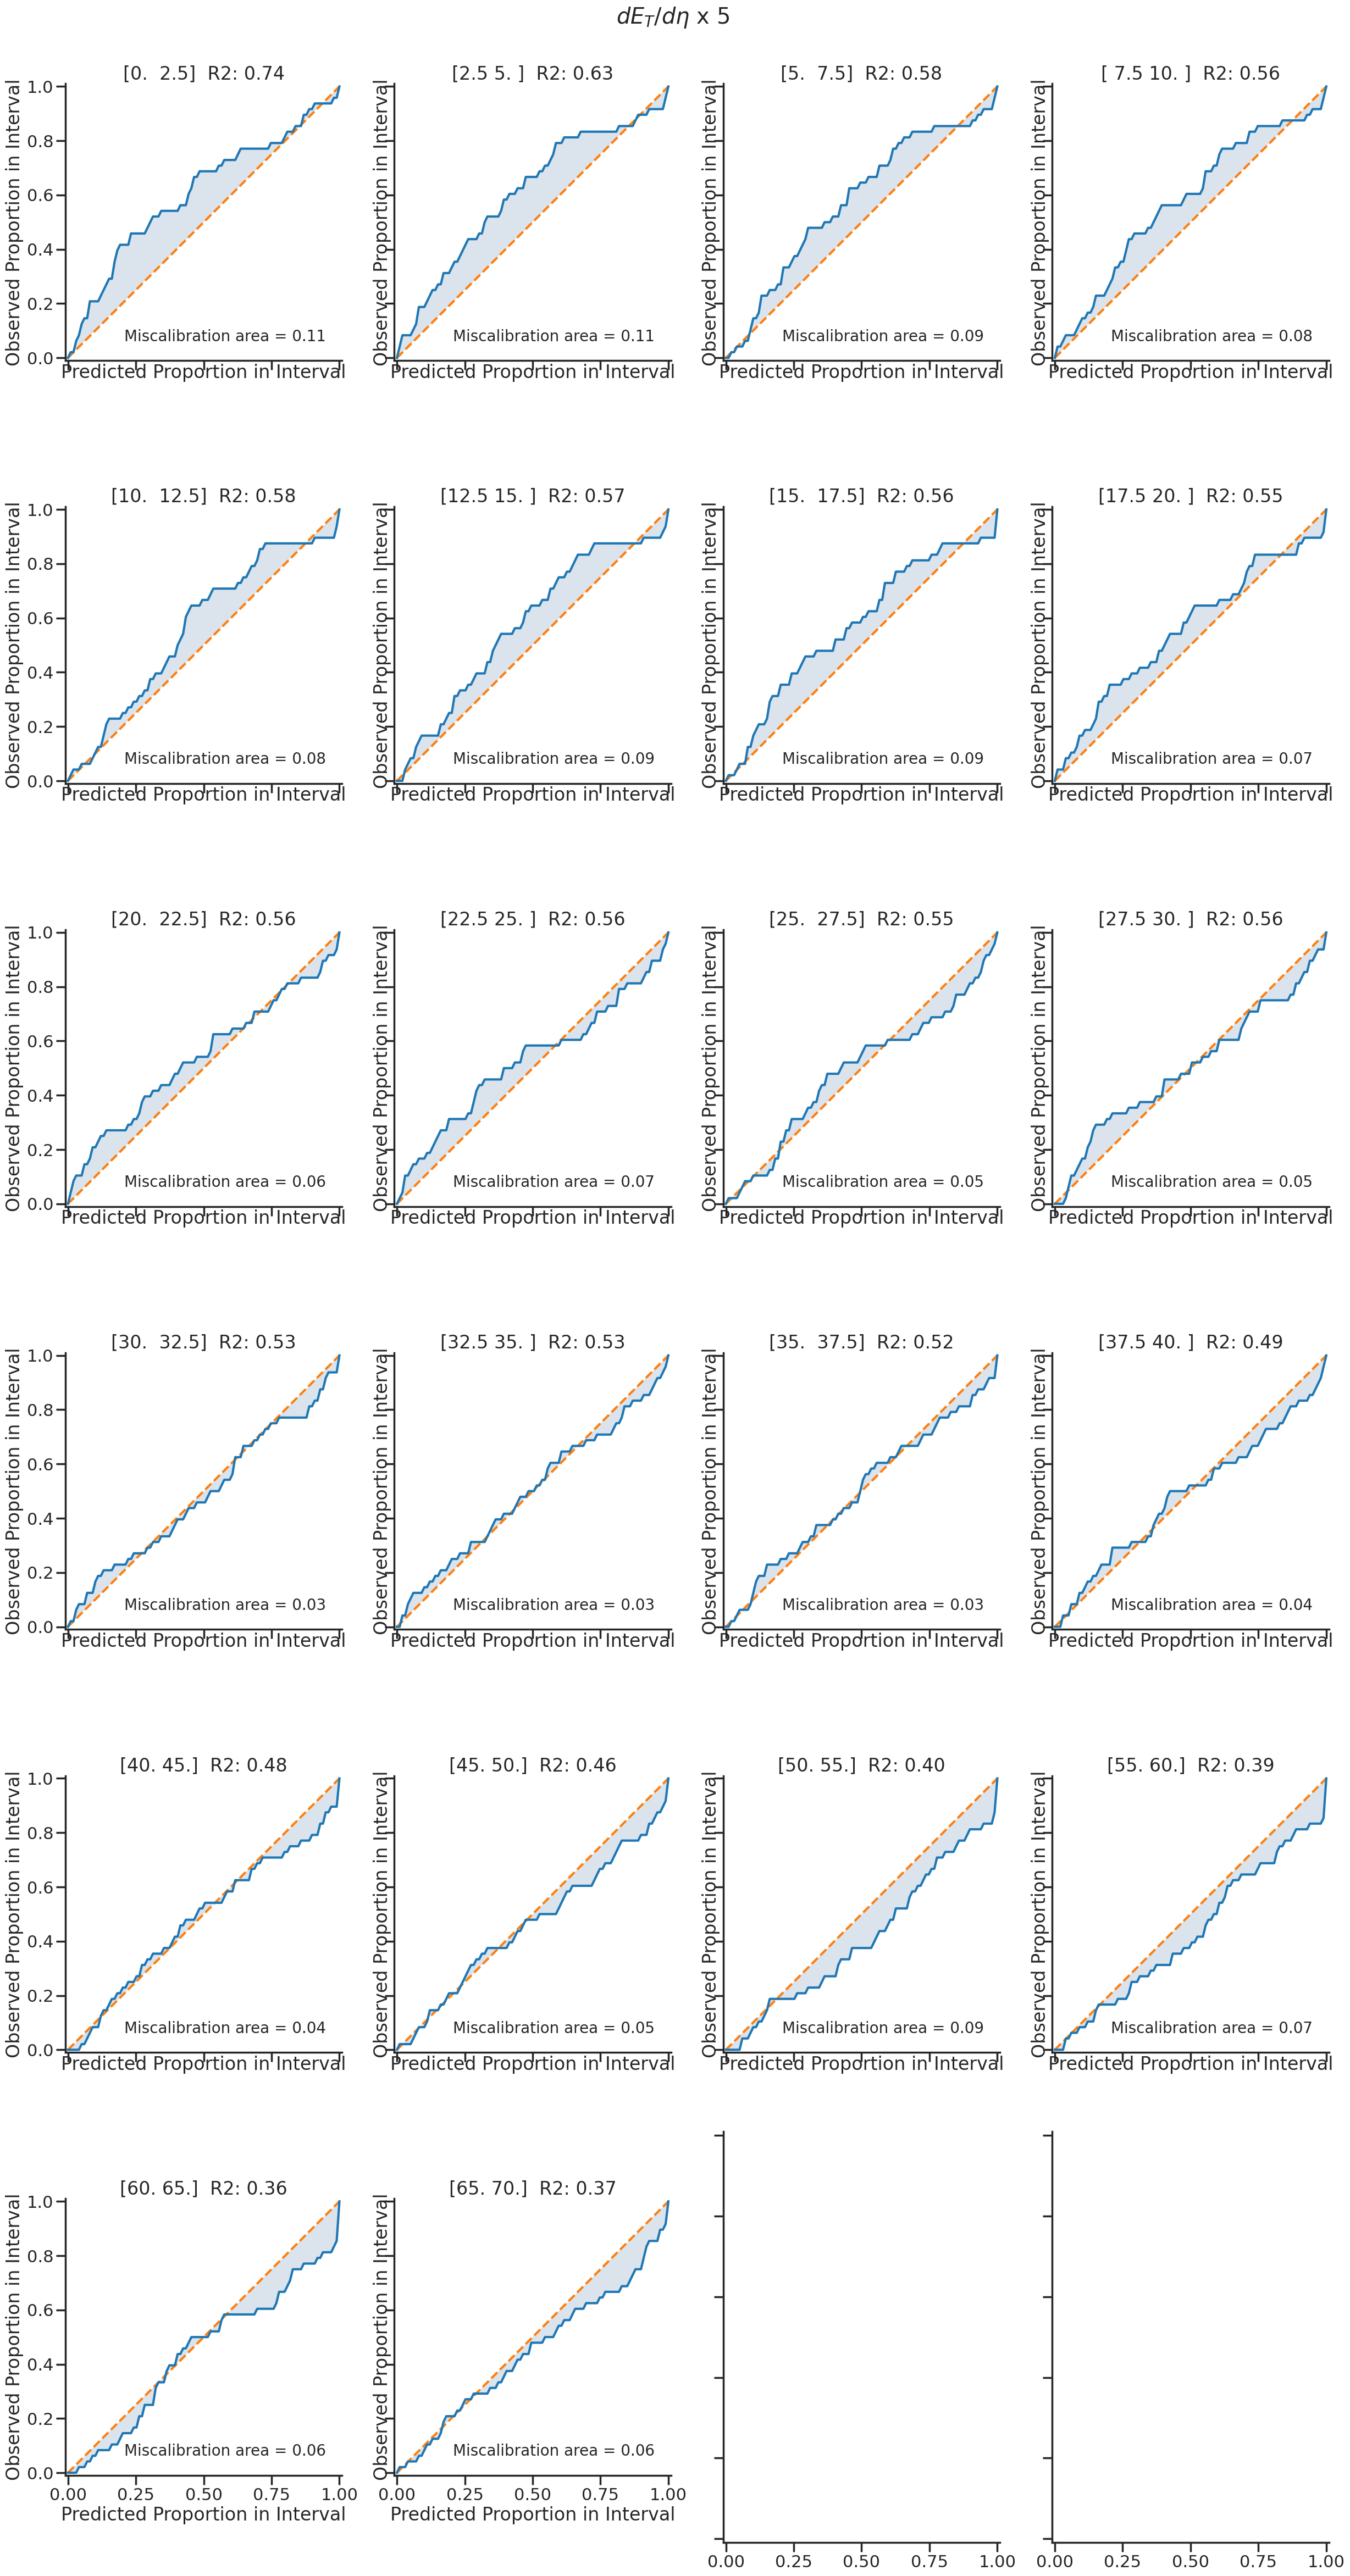

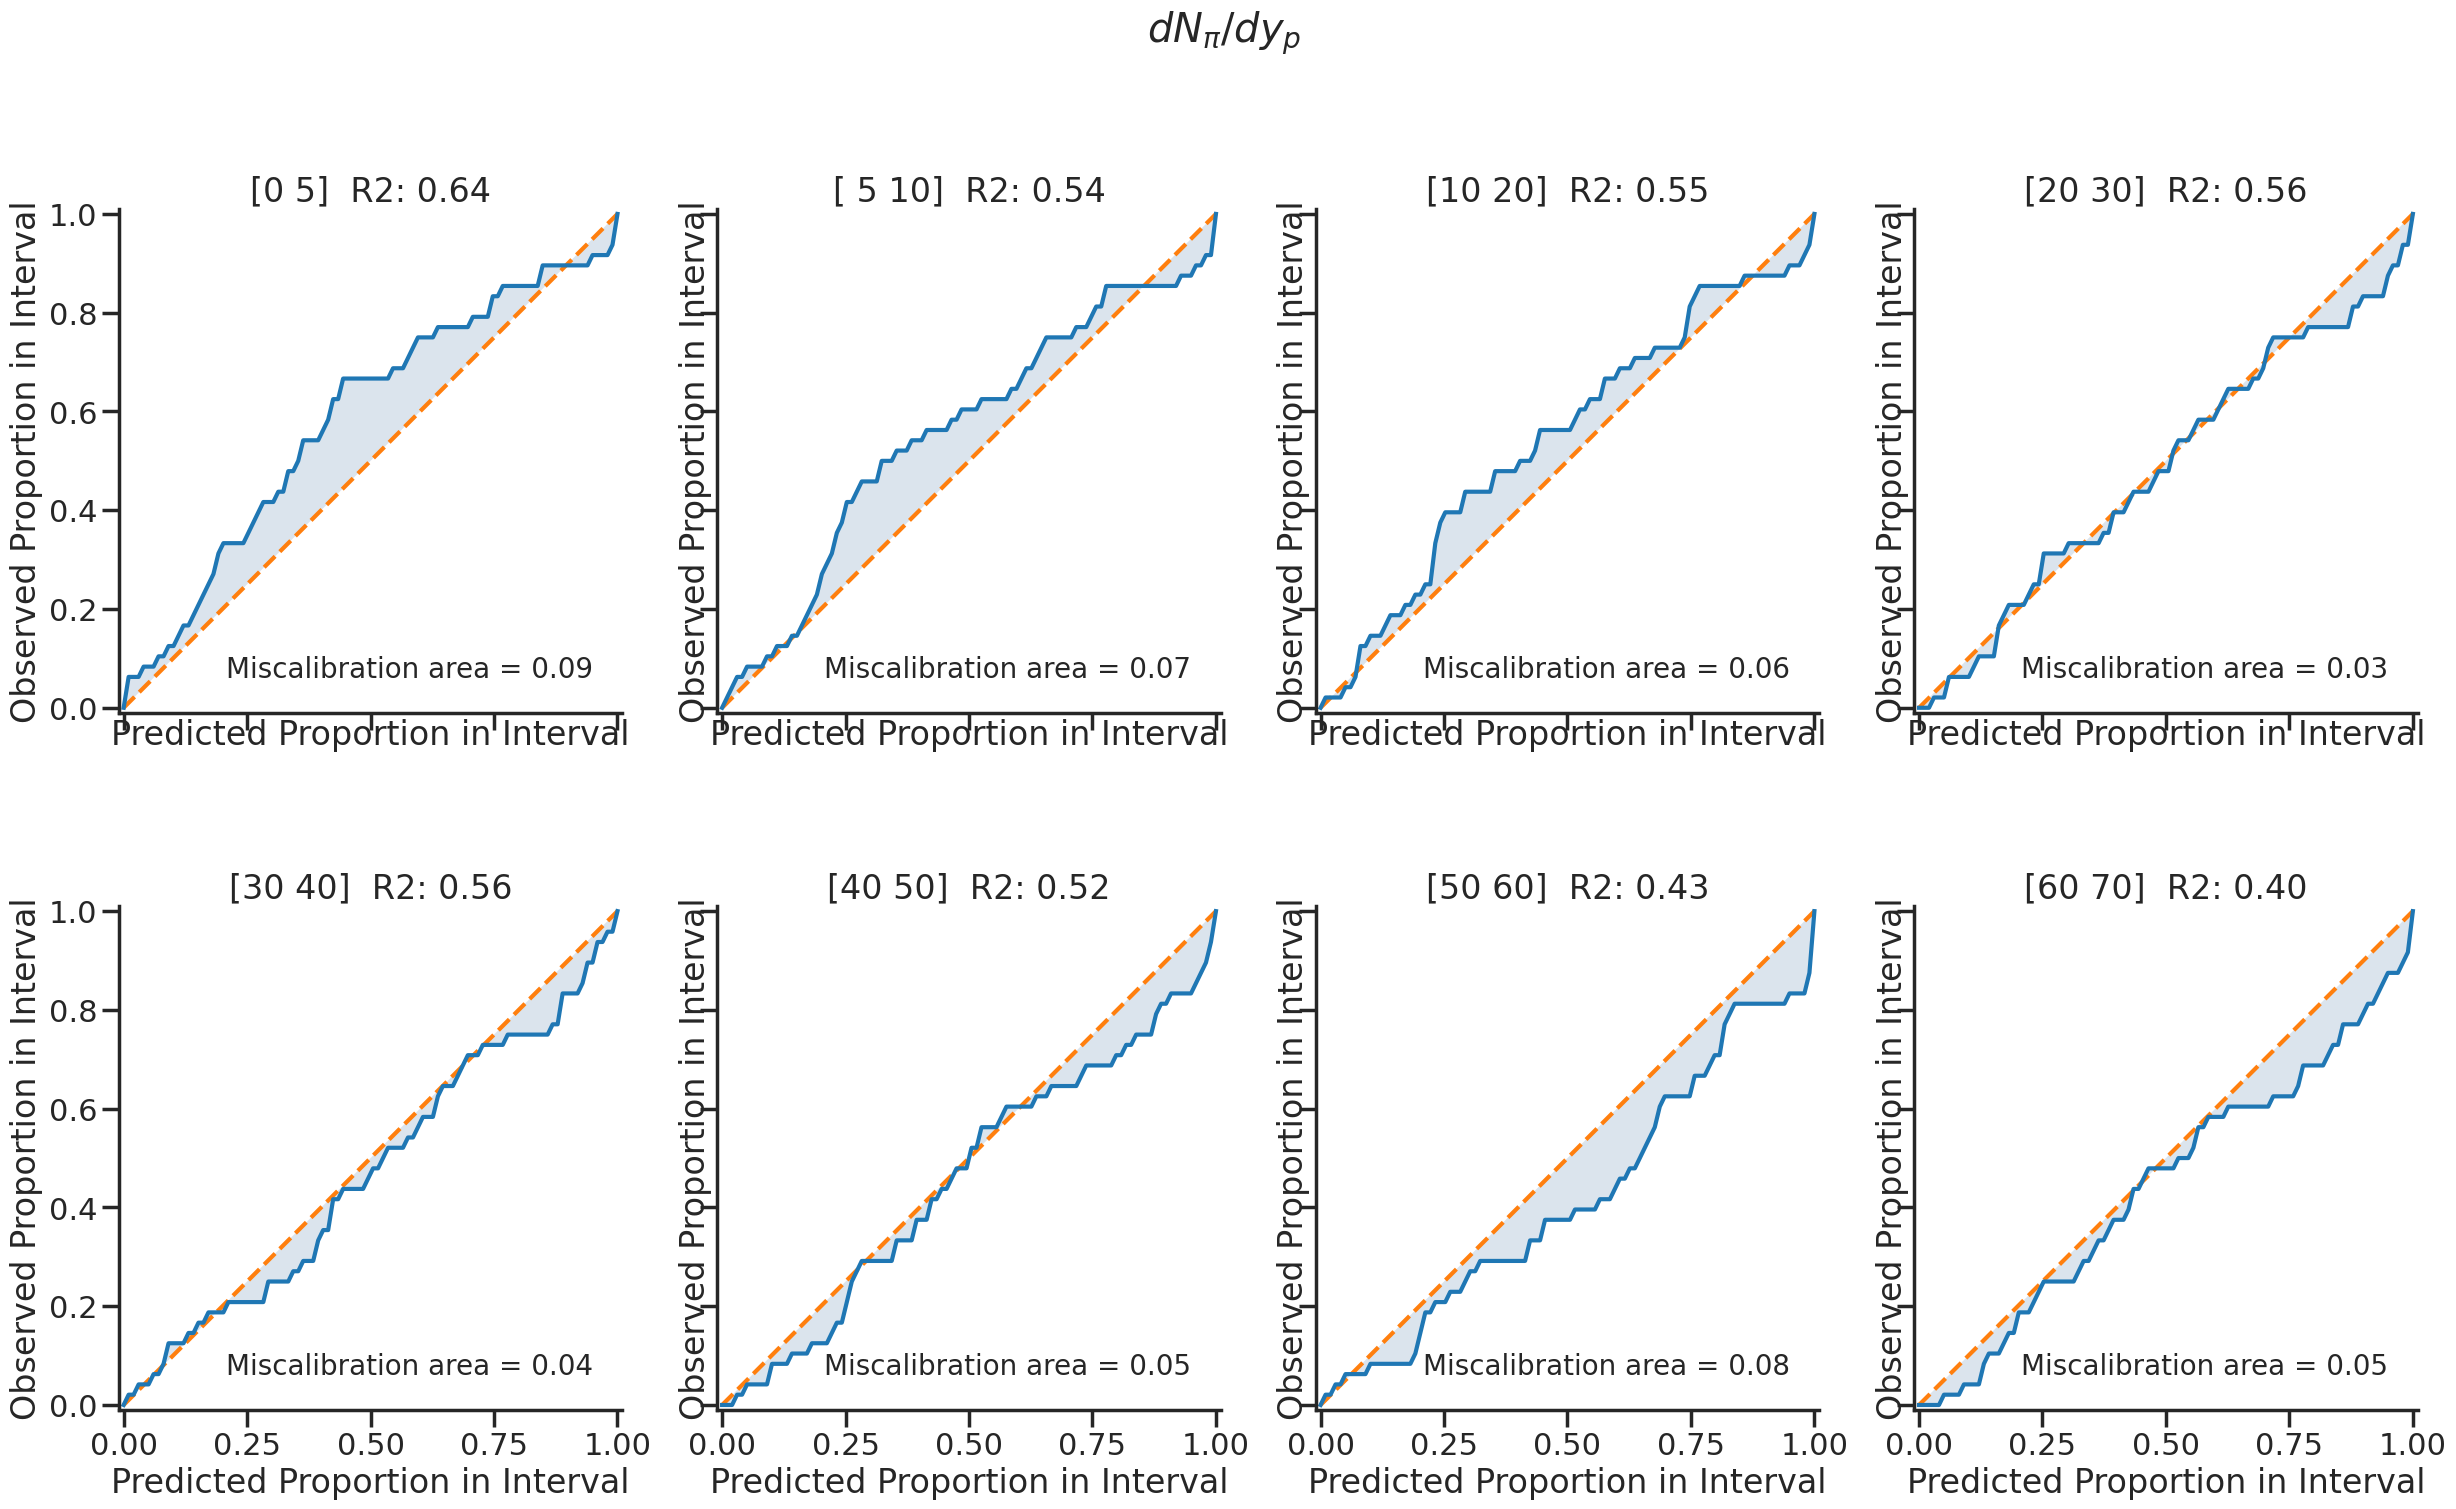

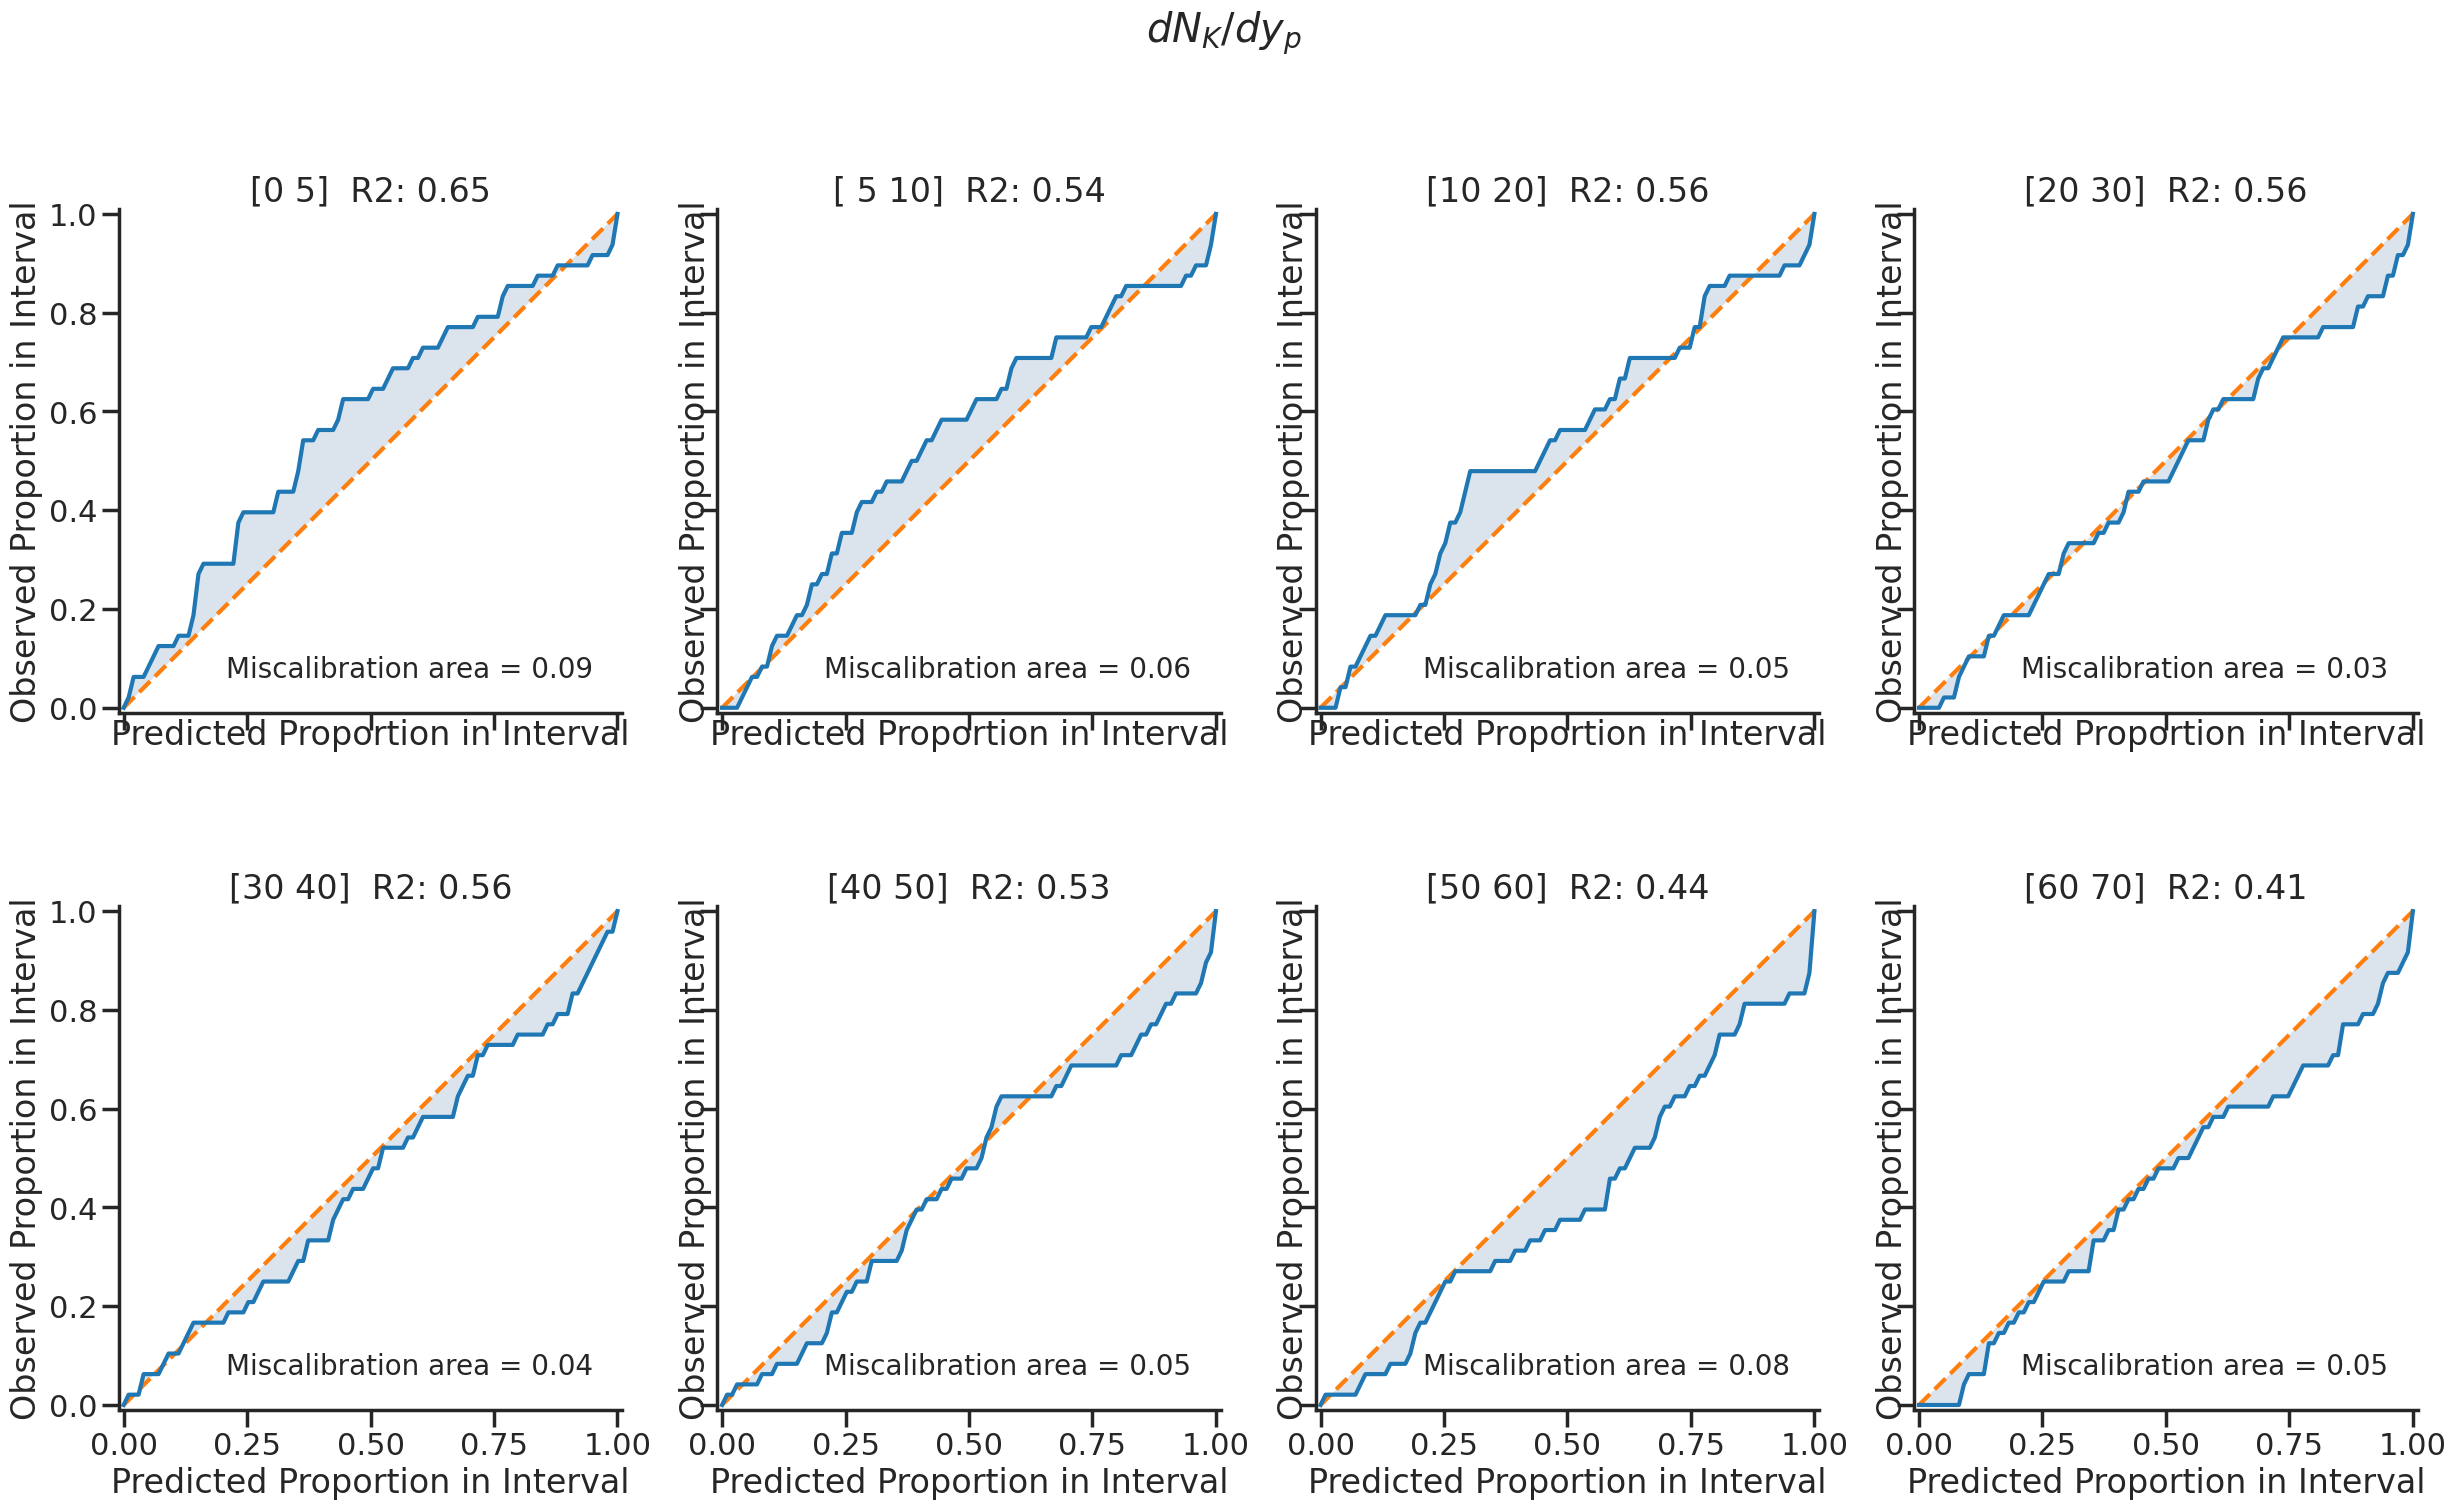

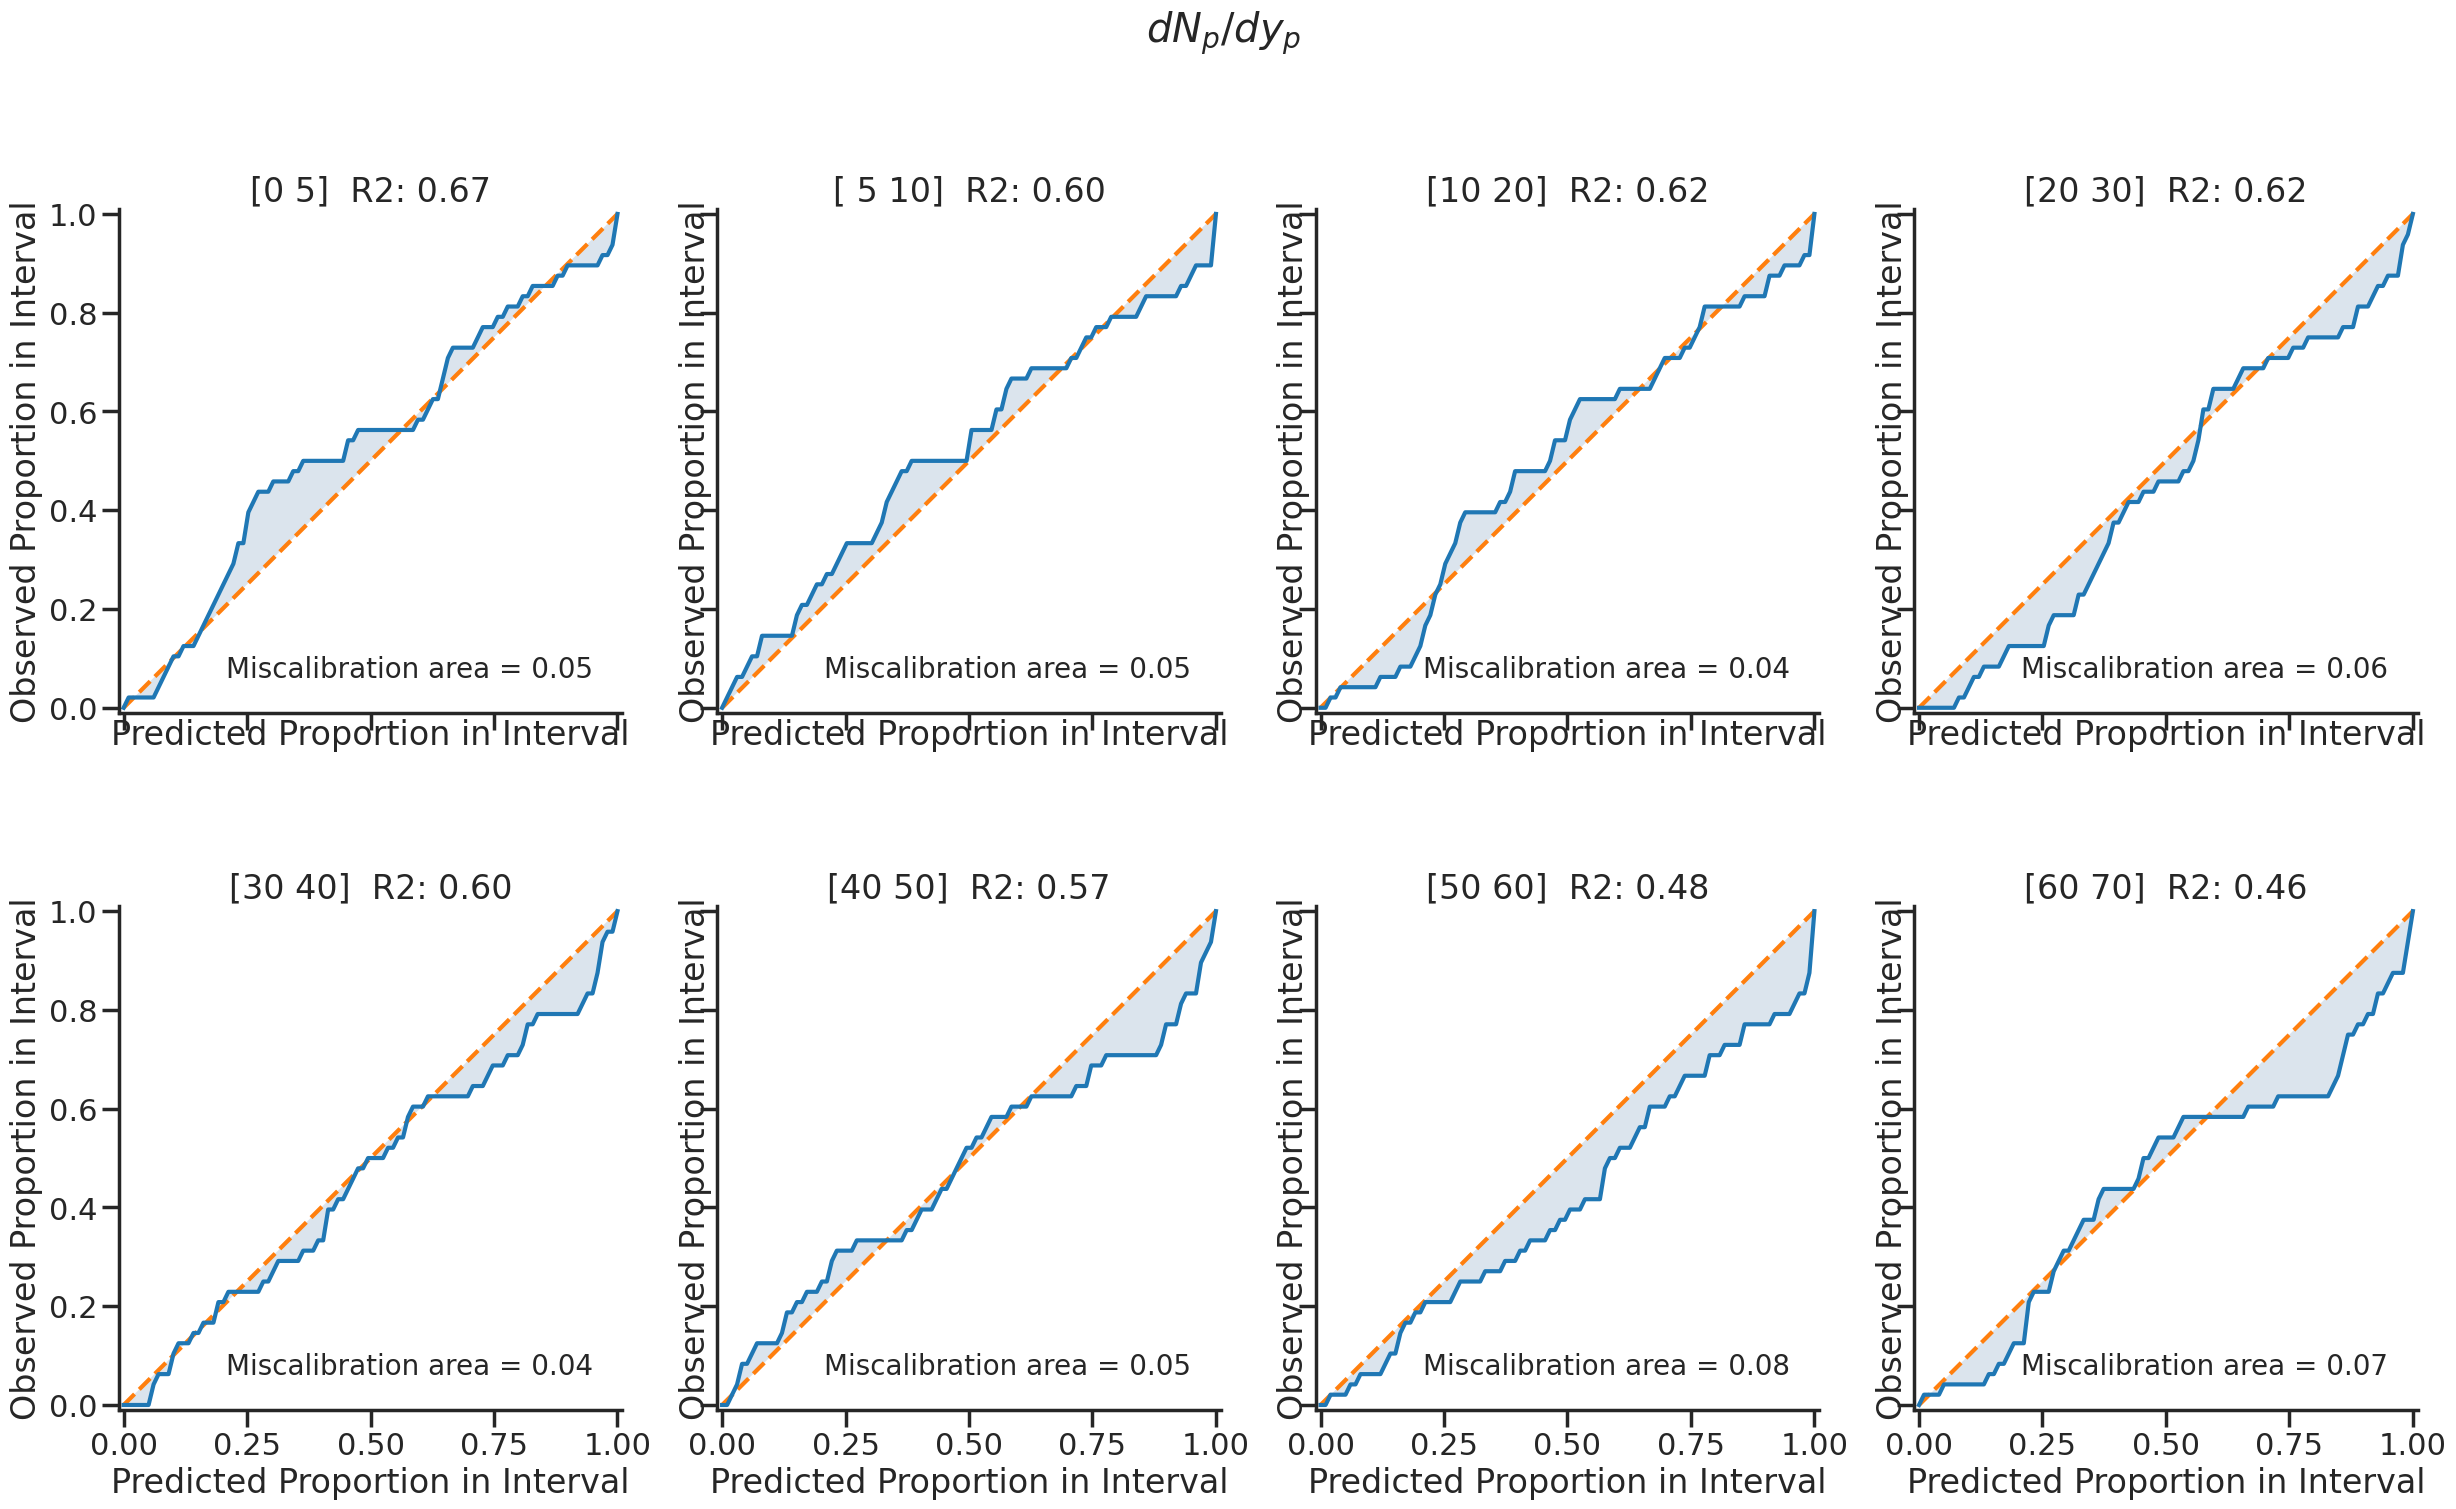

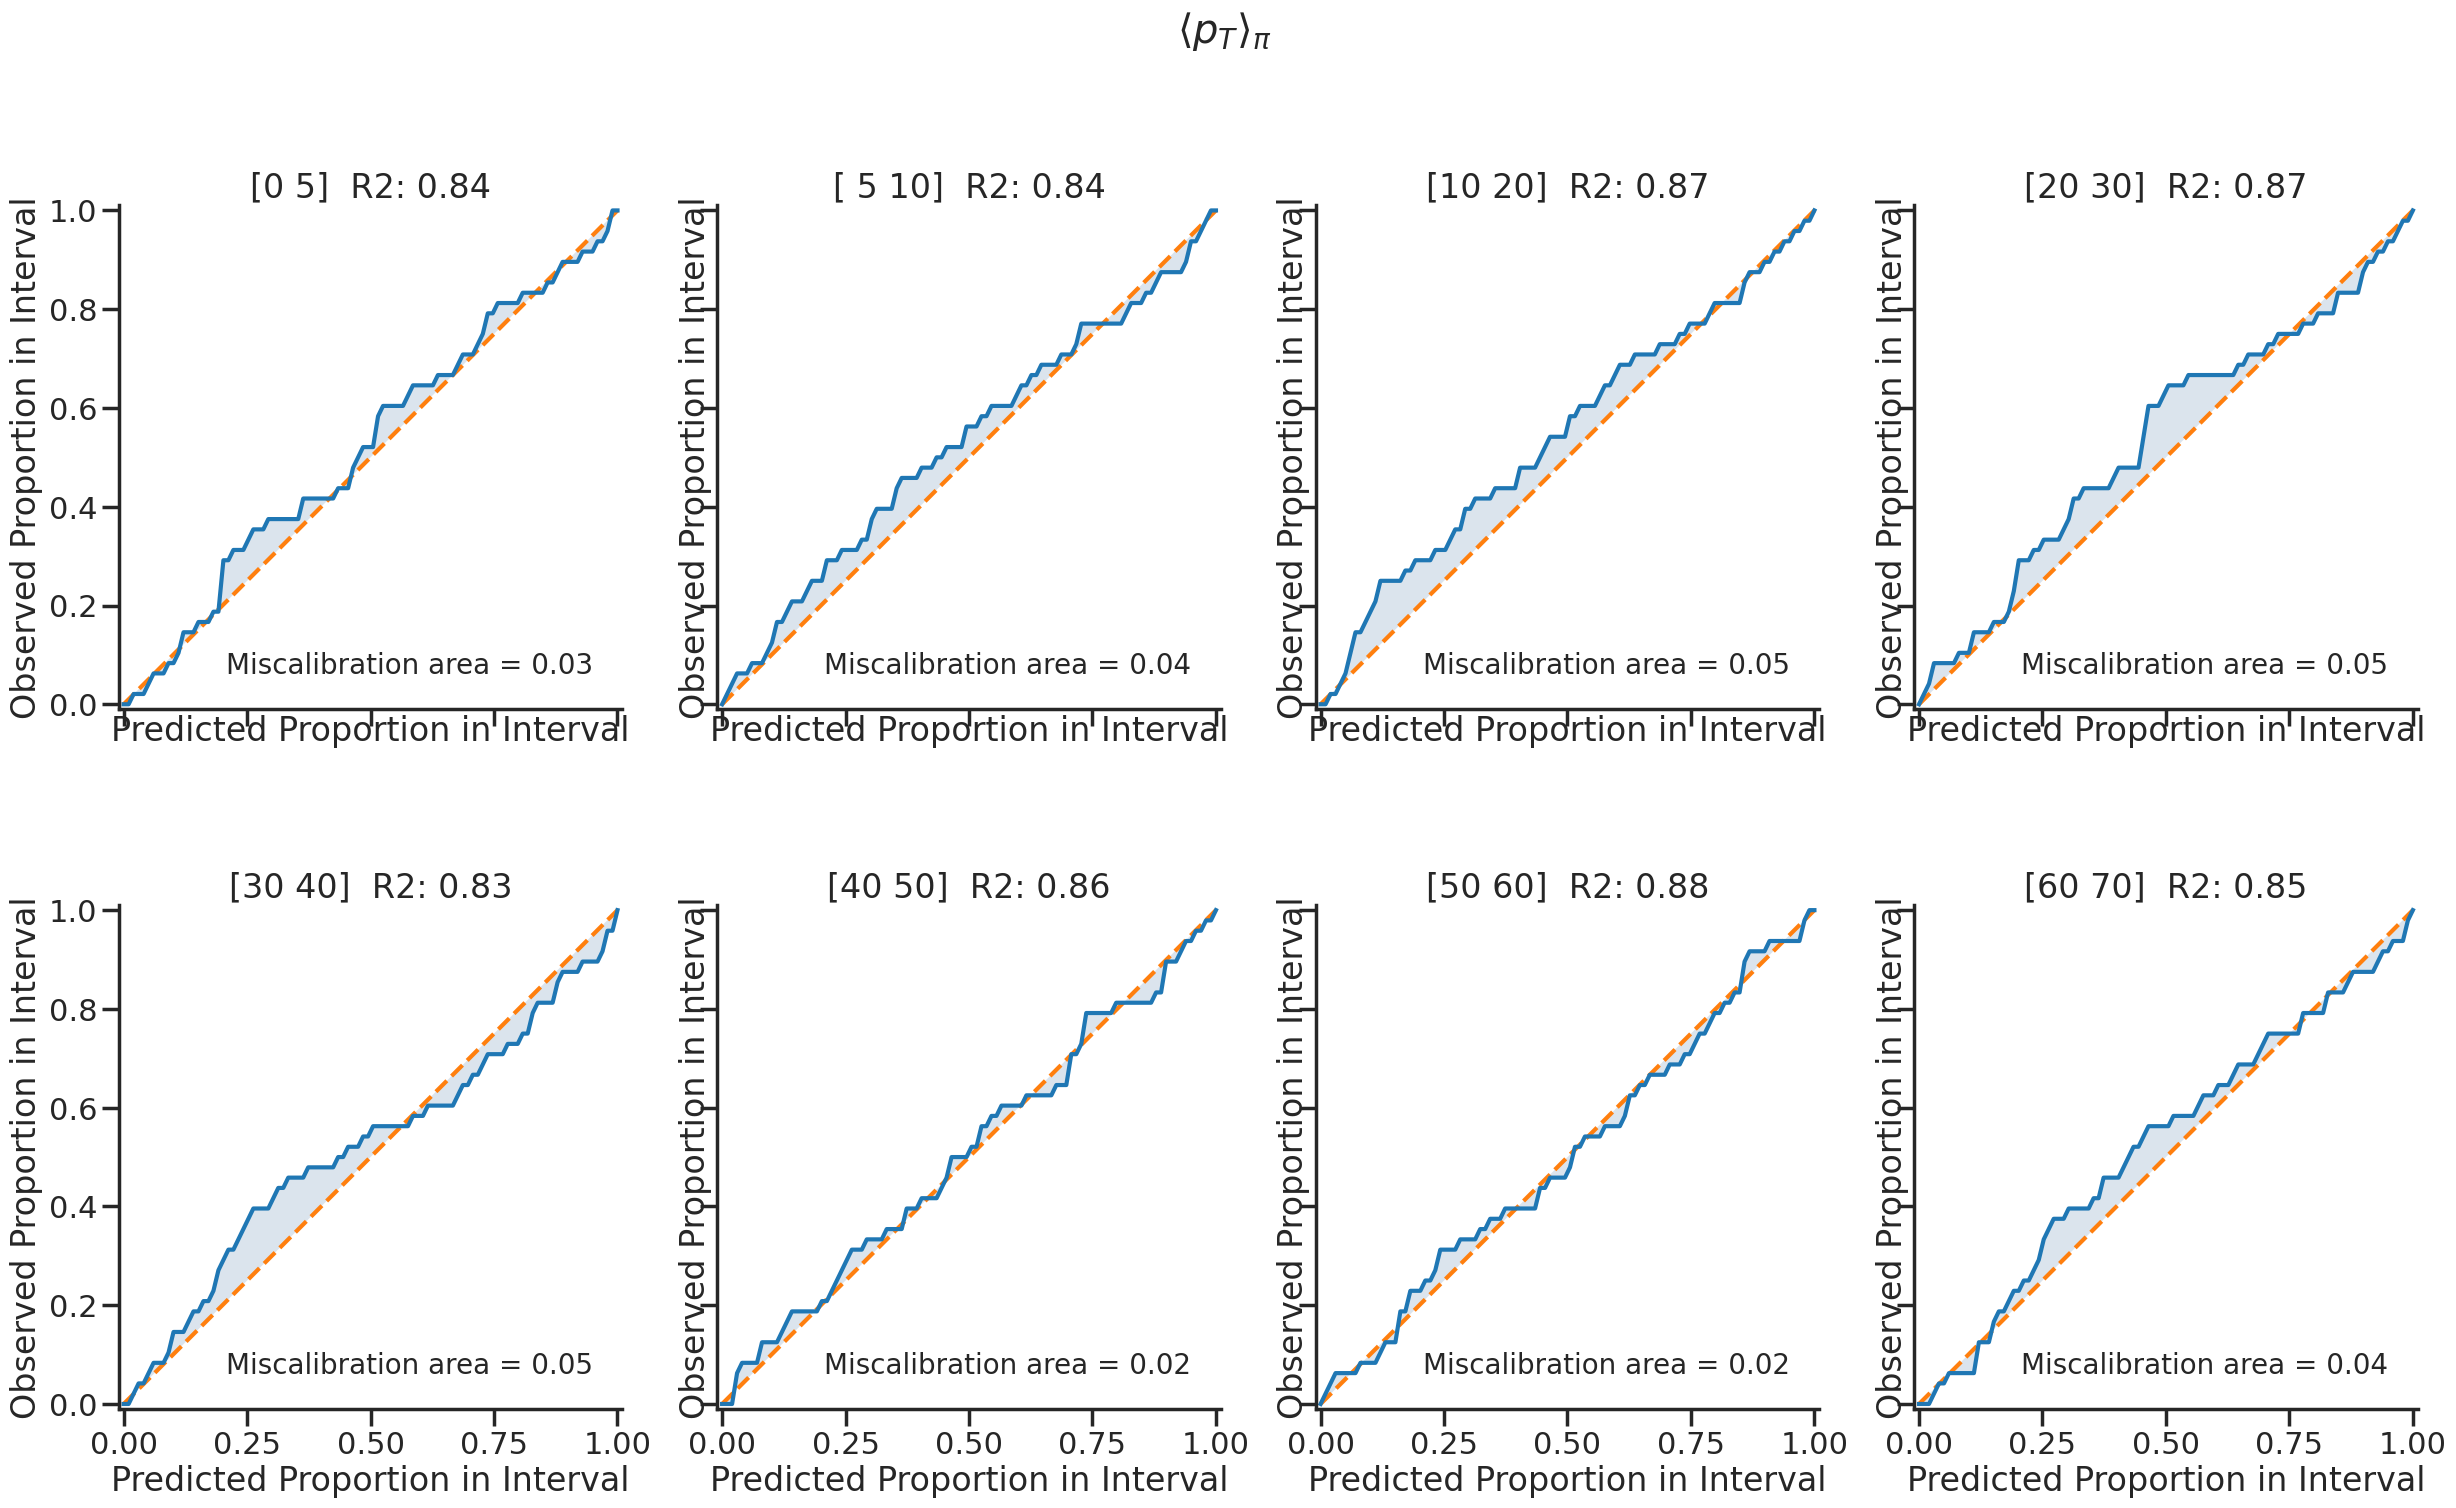

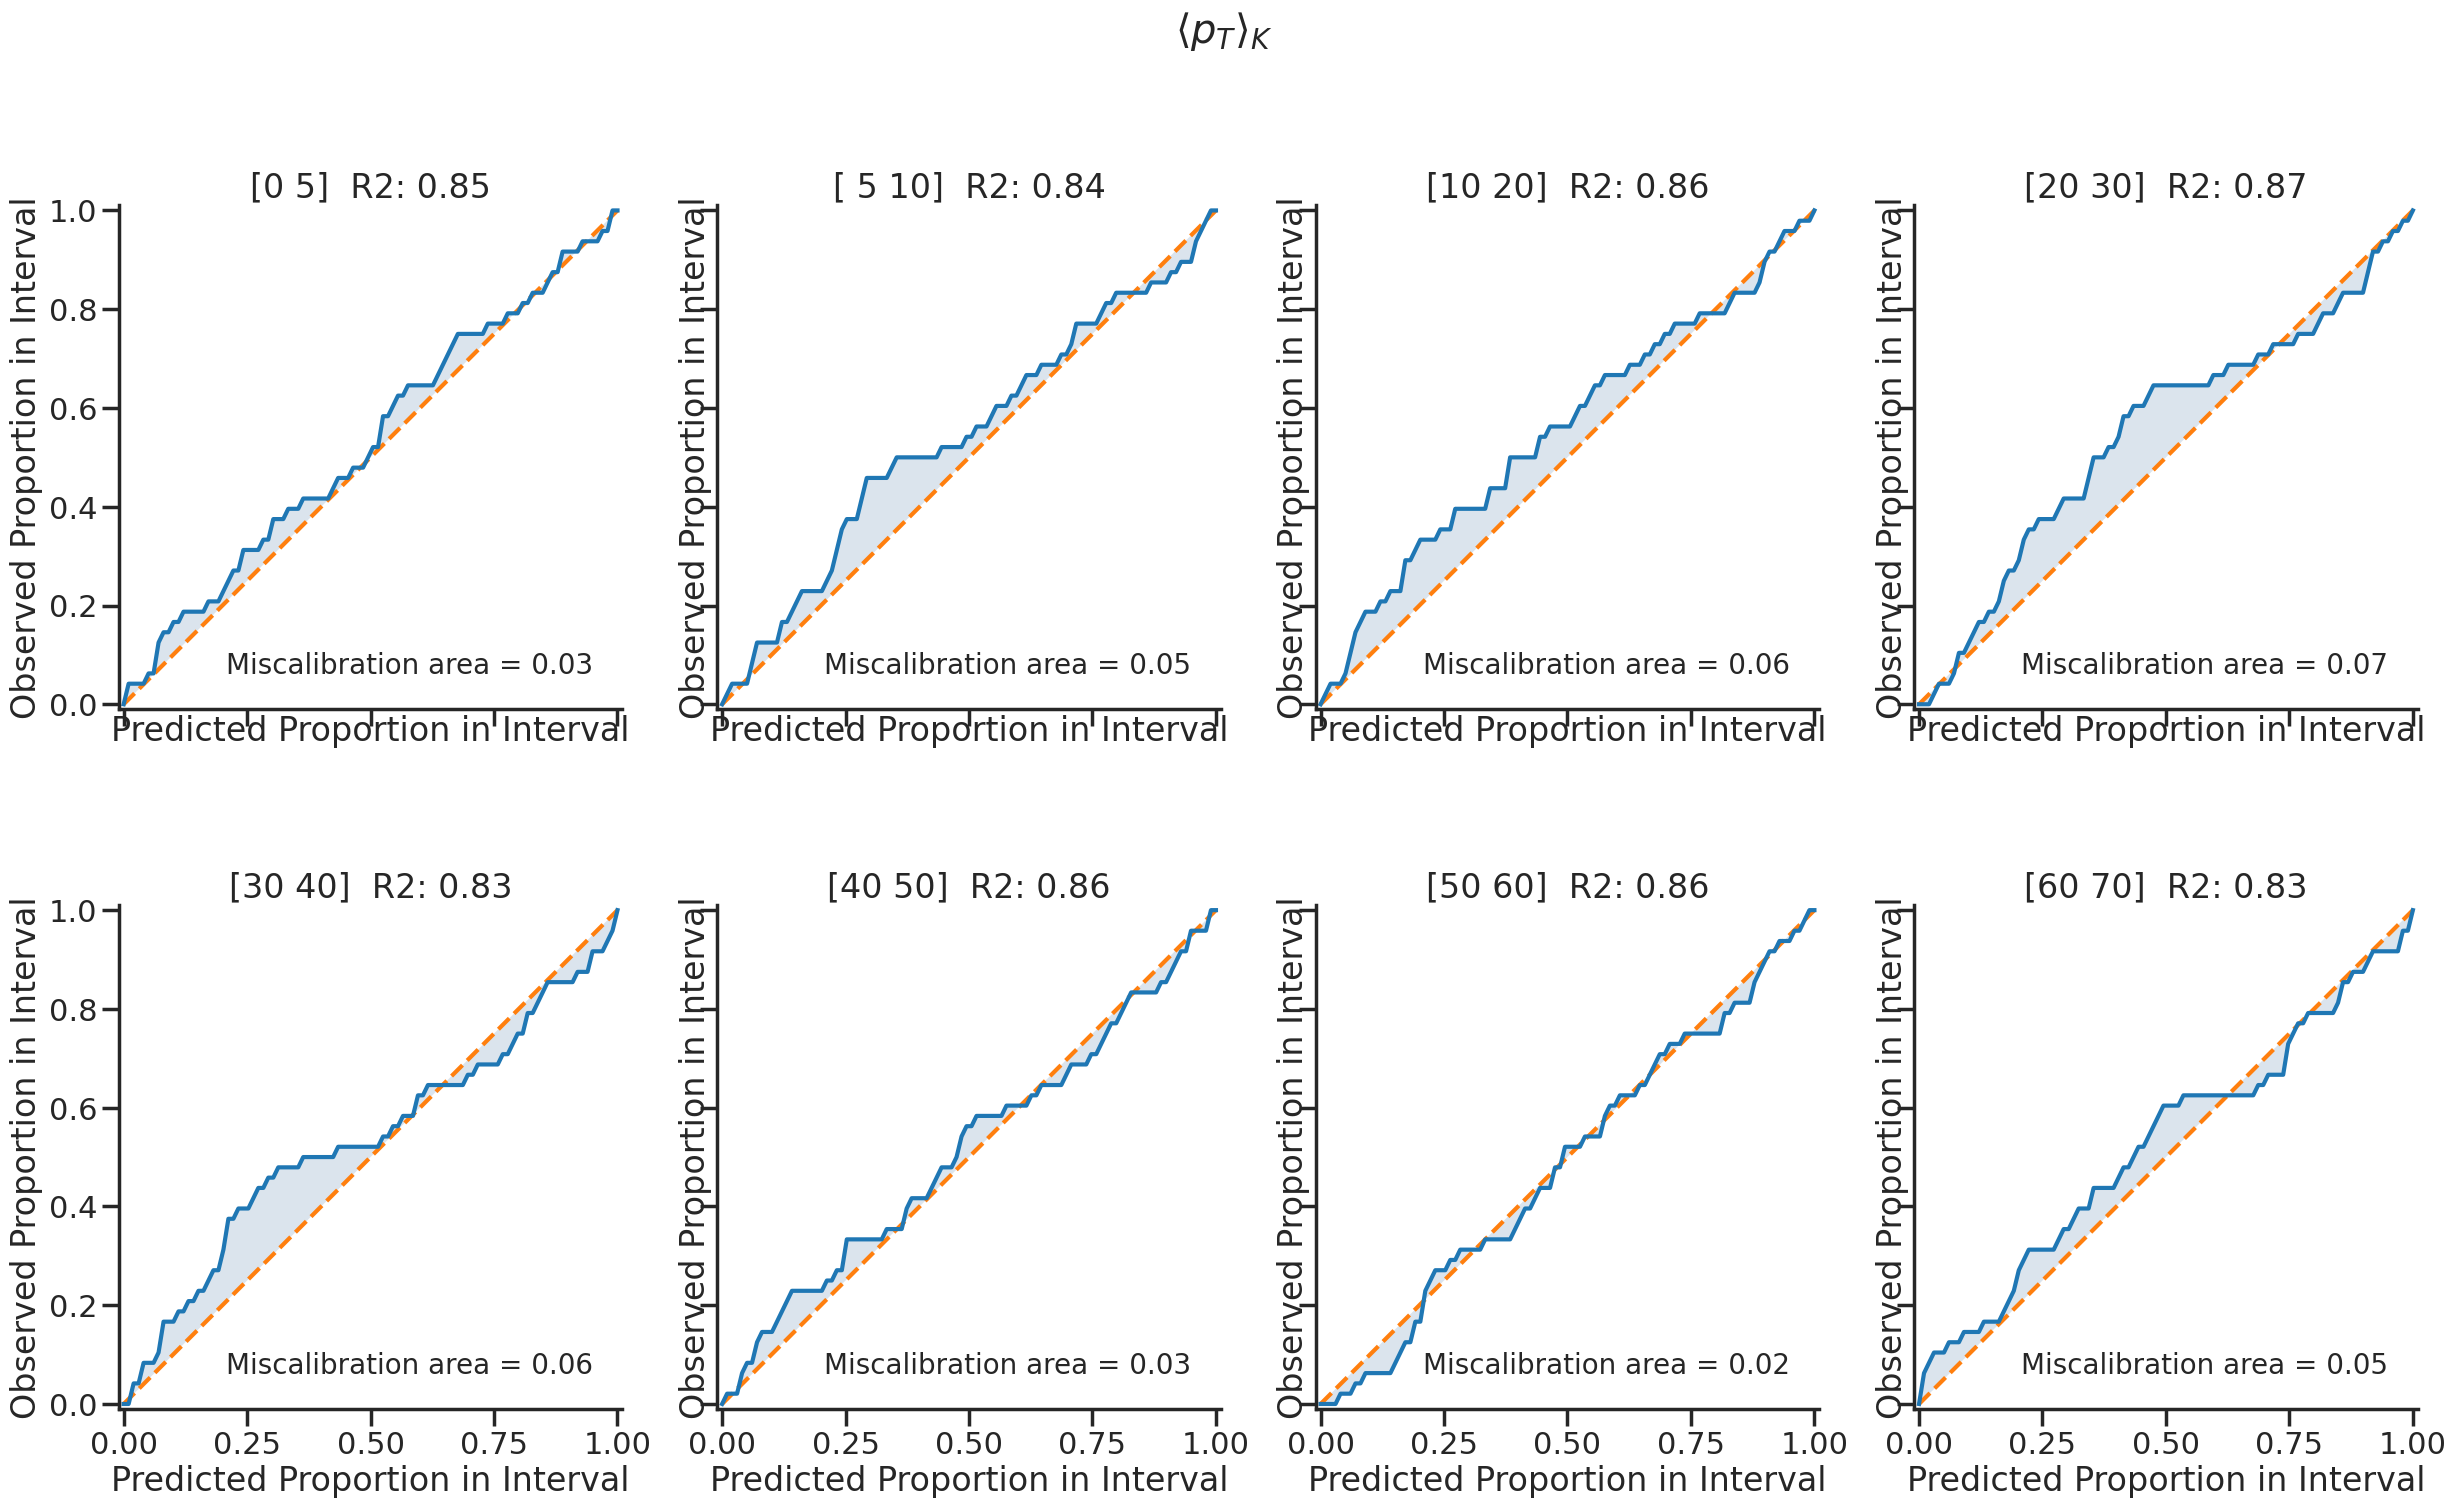

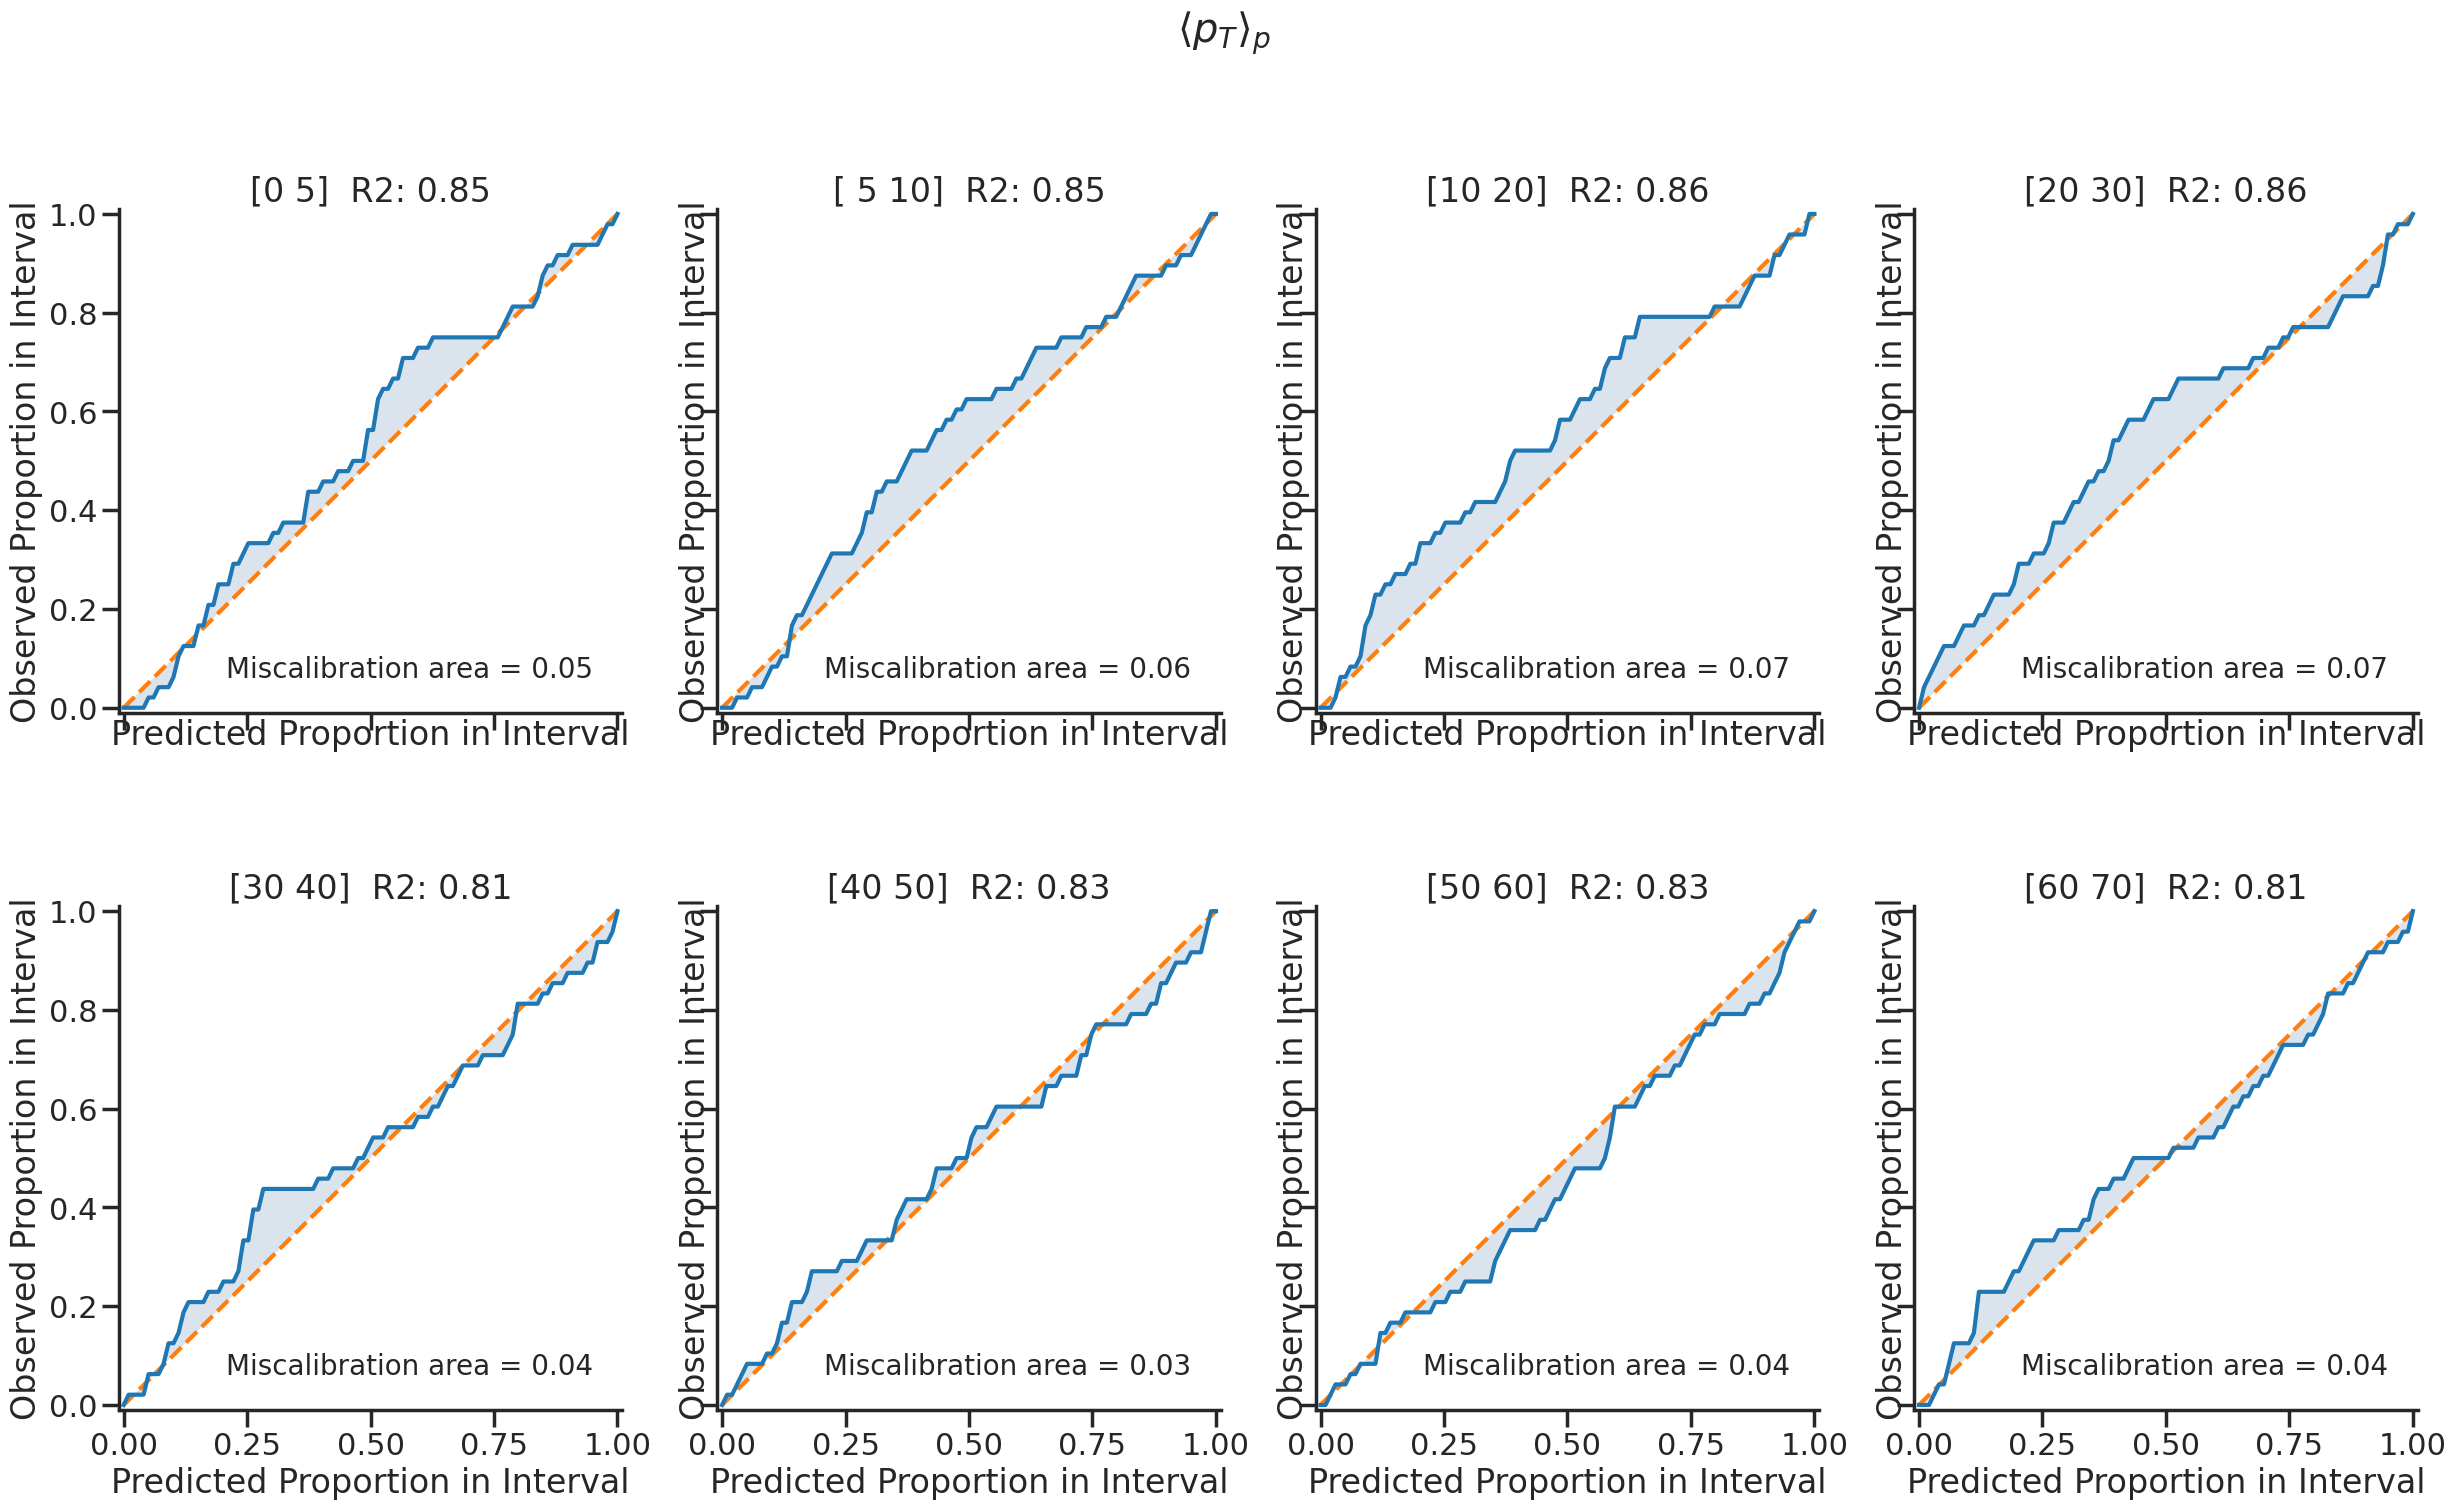

In [65]:
sns.set_context('poster')
for obs in index.keys():
    st = index[obs][0]
    ed = index[obs][1]
    nrw = int(np.ceil((ed-st)/4))
    fig, axs = plt.subplots(nrows=nrw,ncols= 4, figsize=(25,nrw*8),sharex=True, sharey=True)
    for iii,ax in enumerate(axs.flatten()):
        if iii>=ed-st:
            continue;
        ii=st+iii
        mse = sklearn.metrics.mean_squared_error(validation.values[:,ii]\
                                       ,prediction_val[:,ii])
        r = sklearn.metrics.r2_score(validation.values[:,ii]\
                                       ,prediction_val[:,ii])
        #print(r)
        uct.plot_calibration(prediction_val[:,ii], prediction_sig_val[:,ii], validation.values[:,ii], ax=ax)
        #print()
        cen_st = obs_cent_list['Pb-Pb-2760'][obs][iii]
        #print(cen_st)
        ax.set_title(f'{cen_st}  R2: {r:.2f}')
    fig.suptitle(obs_tex_labels[obs])
    plt.tight_layout()
    #save_fig(f'vah_50_{obs}_calibration_curve.png')

#### Trained emulators used for Jetscape SIMS 2021 publication can be found [here]( http://eg1.jetscape.wayne.edu:443/)

#### Homework Exercise
To keep this notebook short we have omitted some of the essential checks in any Bayesian Parameter Inference task. Can you try to build these steps on your own?
 - It is necessary to check if our emulators are good enough. Can you perform some Emulator validations to check this?
 - It is important that our chosen prior ranges for model parameters can produce observables in a range which capture the experimental observations. Can you perform prior predictive checks?

#### <center> We have a fast way to predict observables (All 110) and also get the prediction error matrix for any point in the input model parameters space (17 dimensional)!

### Step 4: Bayesian parameter inference

Bayesian interpretation of probability let us assign probability to any hypothesis based on the knowledge we have about it. Under this interpretation, Bayes theorem becomes a powerful inference tool. 

$$ P({\theta|Y_{exp}}) = \frac{P(Y_{exp}|\theta)P(\theta)}{P(Y_{exp})} $$

$P(\theta) : Prior\:knowledge\:about\:the\:model\:parameters$

$P(Y_{exp}|\theta) : Likelihood\:-\:How\:likely\:is\:it\:it\:to\:observe\:experimental\:data \:(Y_{exp}\:)\;given\:model\:parameter\:values\:\theta $

$P(Y_{exp}) : Evidence $


#### 4.1: Closure test

In this session we will not use the actual experimental data to do our Bayesian parameter inference. Instead we will use data generated from the simulation for a known set of parameter values as our pseudo experimental data. 

Let, $$Y_{exp} = Y_{simulation}(\theta_*)$$

Doing a Bayesian parameter inference using the data generated from the model for known parameter values is called a closure test. Because we know the true value of these parameters ($\theta_*$) we will be able compare the inferred values for the model parameters with the true value to validate our Bayesian inference work flow before moving on to the actual inference. This closure test is an essential step in any Bayesian parameter inference.

#### 4.2 Prior

We will assume a uniform prior for the parameters. This is an uninformative prior. Although it looks harmless to assume uniform priors, special care should be taken to see how this choice of prior can influence the outcome of the inference (prior sensitivity checks). It is always better to use weakly informative priors instead of uniform priors when possible. 

In [66]:
prior_df.head()

,Pb_Pb,Mean,Width,Dist,Flactutation,Temp,Kink,eta_s,Slope_low,Slope_high,Max,Temp_peak,Width_peak,Asym_peak,R
min,10.0,-0.7,0.5,0.0,0.3,0.135,0.13,0.01,-2.0,-1.0,0.01,0.12,0.025,-0.8,0.3
max,30.0,0.7,1.5,1.7,2.0,0.165,0.30,0.20,1.0,2.0,0.25,0.30,0.150,0.8,1.0


In [67]:
#### Block 21 #### Please refer to this number in your questions
def log_prior(model_parameters):
    """
    Uniform Prior. Evaluvate prior for model. 
    
    Parameters
    ----------
    model_parameters : 17 dimensional list of floats
    
    Return
    ----------
    unnormalized probability : float 
    
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    else:
        lp = -np.inf
    return lp

#### 4.3: Likelihood

In [68]:
#### Block 22 #### Please refer to this number in your questions
def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
  #  print(L.diagonal())
    a=np.ones(len(L.diagonal()))*1e-10
    #print(a)
    #print(L)
   # L=L+np.diag(a)
    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

We assume the likelihood to be a multivariate-normal distribution. 

$$P(Y_{exp}|\theta) = \frac{1}{\sqrt{2\pi |[\Sigma_{exp}+\Sigma_{sim}({\theta})]|}} \exp\left(-[Y_{exp}-Y_{sim}({\theta})]^T [\Sigma_{exp}+\Sigma_{sim}({\theta})]^{-1} [Y_{exp}-Y_{sim}({\theta})] \right)$$

In [69]:
#### Block 24 #### Please refer to this number in your questions
# Covariance truncation error from keeping subset of PC is not included
def log_like(model_parameters):
    """
        Parameters
    ----------
    model_parameters : 17 dimensional list of floats
    
    Return
    ----------
    unnormalized probability : float 
        
    """
    mn,var=predict_observables(model_parameters)
    delta_y=mn-y_exp.reshape(1,-1)
    delta_y=delta_y.flatten()
    
    exp_var=np.diag(y_exp_variance)
    
    total_var=var + exp_var
    #only_diagonal=np.diag(total_var.diagonal())
    return mvn_loglike(delta_y,total_var)

#### 4.4: Posterior

In [70]:
#### Block 23 #### Please refer to this number in your questions
# Covariance truncation error from keeping subset of PC is not included
def log_posterior(model_parameters):
    """
        Parameters
    ----------
    model_parameters : 17 dimensional list of floats
    
    Return
    ----------
    unnormalized probability : float 
    """
    
    mn,var=predict_observables(model_parameters)
    delta_y=mn-y_exp.reshape(1,-1)
    delta_y=delta_y.flatten()
    
    exp_var=np.diag(y_exp_variance)
    
    total_var=var + exp_var
    #only_diagonal=np.diag(total_var.diagonal())
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)

In [ ]:
#### Block 25 #### Please refer to this number in your questions

# If false, uses pre-generated MCMC chains.
# If true, runs MCMC.
run_mcmc =True

# Here we actually perform the MCMC Sampling
filename = data_path(name+'ptemcee_closure')

ntemps=50
Tmax = np.inf

nwalkers = 200 # Typically 10*ndim
ndim = 15
nburnin = 1000 # The number of steps it takes for the walkers to thermalize
niterations= 1000 # The number of samples to draw once thermalized
nthin = 10 # Record every nthin-th iteration

nthreads = 5 # Easy parallelization! 

min_theta = [1.625] # Lower bound for initializing walkers
max_theta = [24.79] # Upper bound for initializing walkers

if run_mcmc:

    # 2. Instantiate the sampler object with the parameters, data, likelihood, and prior.
    
    #sampler=PTSampler(ntemps, nwalkers, ndim, logl, logp, threads=nthreads, betas=betas)
    ptsampler_ex=ptemcee.Sampler(nwalkers, ndim, log_like, log_prior, ntemps, 
                      threads=nthreads, Tmax=Tmax)

    # 3. Initialize the walkers at random positions in our 99% prior range
    pos0 = design_min + (design_max - design_min) * np.random.rand(ntemps, nwalkers, ndim)

    # 4. Run the sampler's burn-in iterations
    print("Running burn-in phase")
    for p, lnprob, lnlike in ptsampler_ex.sample(pos0, iterations=nburnin,adapt=True):
        pass
    ptsampler_ex.reset() # Discard previous samples from the chain, but keep the position

    print("Running MCMC chains")
    # 5. Now we sample for nwalkers*niterations, recording every nthin-th sample
    for p, lnprob, lnlike in ptsampler_ex.sample(p, iterations=niterations, thin=nthin,adapt=True):
        pass 

    print('Done MCMC')

    mean_acc_frac = np.mean(ptsampler_ex.acceptance_fraction)
    print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
          f"(in total {nwalkers*niterations} steps)")
    
    # We only analyze the zero temperature MCMC samples
    
    #np.save(name+'ptemcee', )
   # closure_ex_chain = ptsampler_ex.chain[0, :, :, :].reshape((-1, ndim))
    samples = ptsampler_ex.chain[0, :, :, :].reshape((-1, ndim))
    samples_df= pd.DataFrame(samples, columns=model_param_dsgn)
    samples_df.to_csv(filename)
else:
    samples_df = pd.read_csv(filename, index_col=0)
    
et = time.time()
#print(f'Time it took to generate MCMC chain {et-st}')

Running burn-in phase


In [ ]:
samples_df.shape

In [ ]:
samples_df.head()

### Homework exercise
 - Can you perform some MCMC diagnostic tests that you know on these posterior chains to make sure that we can trust these samples?

#### 4.5: Find MAP parameters

Try to optimize and find model parameters that maximize the posterior

In [ ]:
#### Block 26 #### Please refer to this number in your questions

# If false, do not try to find the Maximum A posterior values.
find_map_param = True
if find_map_param == True:
    bounds=[(a,b) for (a,b) in zip(design_min,design_max)]
    rslt = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                           bounds=bounds,
                                           maxiter=100000,
                                          disp=True,
                                          tol=1e-9,
                                         )
    print(rslt.x)

In [ ]:
map_values_saved=rslt.x

In [ ]:
map_values_saved

In [ ]:
#### Block 27 #### Please refer to this number in your questions

#Loead pre calculated MAP parametrs
#map_values_saved = np.array([16.66027828, -0.7, 1.12137174 , 0.91485971 , 2.16788304, 1.19824104
#  ,0.13902944 , 0.22238455, -0.54441712 , 1.09798352, 0.10850543, 0.1342023
#  ,0.21801985 , 0.12026427, -0.05440159 , 7.76622601, 0.15233504])

In [ ]:
#### Block 28 #### Please refer to this number in your questions

#The true model parametrs for which we generated pseudo experimental data
#truth = validation_design.values[0,:]

#### 4.6: Posterior distribution

In [ ]:
sns.color_palette('bright')

In [ ]:
#### Block 30 #### Please refer to this number in your questions


sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")
map_parameters=map_values_saved.flatten()
n_samples_prior = 20000
prune = 1
#map_parameters = rslt.x
sns.set_palette('bright')
observables_to_plot=[0, 1, 2 ,3 , 4, 5, 14]
g = sns.PairGrid(samples_df.iloc[0:n_samples_prior:prune,observables_to_plot], corner=True, diag_sharey=False)
g.map_lower(sns.kdeplot, color=sns.color_palette()[4], fill=True)
#g.map_upper(sns.kdeplot, shade=True, color=sns.color_palette()[0])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[4])
for n,i in enumerate(observables_to_plot):
    ax=g.axes[n][n]
    ax.axvline(x=map_parameters[i], ls='--', c=sns.color_palette()[9], label='MAP')
    #ax.text(0.0,1,s= f'{map_parameters[i]:.3f}',fontdict={'color':sns.color_palette()[9]}, transform=ax.transAxes)
    #ax.axvline(x=truth[i], ls='--', c=sns.color_palette()[3], label = 'Truth')
    #ax.text(0.6,1,s= f'{truth[i]:.3f}',fontdict={'color':sns.color_palette()[3]}, transform=ax.transAxes)
    if n==0:
        ax.legend(loc=1,fontsize='xx-small')
plt.tight_layout()
save_fig(name+"WithoutViscosity")
plt.show()

In [ ]:
#### Block 31 #### Please refer to this number in your questions


sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")
#map_parameters = rslt.x
n_samples_prior = 20000
prune = 1
map_parameters=map_values_saved.flatten()
sns.set_palette('bright')
observables_to_plot=[6, 7 , 8, 9, 10, 11, 12, 13]
g = sns.PairGrid(samples_df.iloc[0:n_samples_prior:prune,observables_to_plot], corner=True, diag_sharey=False)
g.map_lower(sns.kdeplot, color=sns.color_palette()[5], fill=True)
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[1], fill=True)
for n,i in enumerate(observables_to_plot):
    ax=g.axes[n][n]
    ax.axvline(x=map_parameters[i], ls='--', c=sns.color_palette()[9], label= 'MAP')
    #ax.text(0,0.9,s= f'{map_parameters[i]:.3f}', transform=ax.transAxes)
    #ax.axvline(x=truth[i], ls='--', c=sns.color_palette()[3], label = 'Truth')
    #ax.text(0,0.8,s= f'{truth[i]:.3f}', transform=ax.transAxes)
    if n==4:
        ax.legend(loc=0,fontsize='xx-small')    
plt.tight_layout()
save_fig(name+"Viscosity")
plt.show()

#### 4.7: Posterior for the viscosities

Define temperature dependent viscosity functions

In [ ]:
#### Block 33 #### Please refer to this number in your questions


def zeta_over_s(T, zmax, T0, width, asym):
    DeltaT = T - T0
    sign = 1 if DeltaT>0 else -1
    x = DeltaT/(width*(1.+asym*sign))
    return zmax/(1.+x**2)
zeta_over_s = np.vectorize(zeta_over_s)

def eta_over_s(T, T_k, alow, ahigh, etas_k):
    if T < T_k:
        y = etas_k + alow*(T-T_k)
    else:
        y = etas_k + ahigh*(T-T_k)
    if y > 0:
        return y
    else:
        return 0.
eta_over_s = np.vectorize(eta_over_s)

In [ ]:
#### Block 34 #### Please refer to this number in your questions


Tt = np.linspace(0.1, 0.4, 100)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),
                         sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Specefic shear viscosity posterior", wrap=True)

# True temperature dependece of the viscosity

#[T_k, alow, ahigh, etas_k] = truth[[7,8,9,10]]
#true_shear = eta_over_s(Tt, T_k, alow, ahigh, etas_k)


prior_etas = []

for row in np.random.uniform(design_min, design_max,(10000,15))[:,[6,7,8,9]]:
    [T_k, alow, ahigh, etas_k] = row
    prior=[]
    for T in Tt:
        prior.append(eta_over_s(T,T_k,alow,ahigh,etas_k))
    prior_etas.append(prior)
per0_pr,per5_pr,per20_pr,per80_pr,per95_pr,per100_pr=np.percentile(prior_etas,[0,5,20,80,95,100], axis=0)

n_samples_posterior = 20000
prune = 10
posterior_etas = []
    
for row in samples_df.iloc[0:n_samples_posterior:prune,[6,7,8,9]].values:
    [T_k, alow, ahigh, etas_k] = row
    posterior=[]
    for T in Tt:
        posterior.append(eta_over_s(T,T_k,alow,ahigh,etas_k))
    posterior_etas.append(posterior)
per0,per5,per20,per80,per95,per100=np.percentile(posterior_etas,[0,5,20,80,95,100], axis=0)
axes.fill_between(Tt, per0_pr,per100_pr,color=sns.color_palette()[7], alpha=0.1, label='Prior')
axes.fill_between(Tt,per5,per95,color=sns.color_palette()[9], alpha=0.2, label='90% C.I.')
axes.fill_between(Tt,per20,per80, color=sns.color_palette()[9], alpha=0.3, label='60% C.I.')
#axes.plot(Tt, true_shear, color = 'r', label = 'Truth', linewidth=5)
#pos=np.array(prior_etas).T
#axes.violinplot(pos[1::10,:].T, positions=Tt[1::10],widths=0.03)

axes.legend(loc='upper left')
#axes.set_ylim(0,1.2)
axes.set_xlabel('T [GeV]')
axes.set_ylabel('$\eta/s$')
save_fig('shear_posterior')

In [ ]:
#### Block 35 #### Please refer to this number in your questions


Tt = np.linspace(0.1, 0.4, 100)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),
                         sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Specefic bulk viscosity posterior", wrap=True)

# True temperature dependece of the viscosity

#[zmax, T0, width, asym] = truth[[11,12,13,14]]
#true_bulk = zeta_over_s(Tt, zmax, T0, width, asym)


prior_zetas = []

for row in np.random.uniform(design_min, design_max,(10000,15))[:,[10,11,12,13]]:
    [zmax, T0, width, asym] = row   
    prior=[]
    for T in Tt:
        prior.append(zeta_over_s(T,zmax, T0, width, asym))
    prior_zetas.append(prior)
per0_pr,per5_pr,per20_pr,per80_pr,per95_pr,per100_pr=np.percentile(prior_zetas,[0,5,20,80,95,100], axis=0)

n_samples_posterior = 20000
prune = 10
posterior_zetas = []
    
for row in samples_df.iloc[0:n_samples_posterior:prune,[10,11,12,13]].values:
    [zmax, T0, width, asym] = row   
    posterior=[]
    for T in Tt:
        posterior.append(zeta_over_s(T,zmax, T0, width, asym))
    posterior_zetas.append(posterior)
per0,per5,per20,per80,per95,per100=np.percentile(posterior_zetas,[0,5,20,80,95,100], axis=0)
axes.fill_between(Tt, per0_pr,per100_pr,color=sns.color_palette()[7], alpha=0.1, label='Prior')
axes.fill_between(Tt,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
axes.fill_between(Tt,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
#axes.plot(Tt, true_bulk, color = 'r', label = 'Truth', linewidth=5)

#pos=np.array(prior_zetas).T
#axes.violinplot(pos[1::10,:].T, positions=Tt[1::10],widths=0.03)

axes.legend(loc='upper right')
#axes.set_ylim(0,1.2)
axes.set_xlabel('T [GeV]')
axes.set_ylabel('$\zeta/s$')
save_fig('bulk_posterior')

#### 4.8: MAP predictions compared to experimental observables

In [ ]:
#### Block 29 #### Please refer to this number in your questions

mm,vv=predict_observables(map_values_saved)
print(f'Shape of mean {mm.shape} and variance {vv.shape}')

In [ ]:
map_values_saved

In [ ]:
map_values_saved_new = np.array([28.57232622,  0.05714793,  1.18536305,  0.88569411,  0.93453349,
        0.14898859,  0.20862629,  0.11218337, -1.12039581,  1.58537076,
        0.14338342,  0.17981994,  0.09043189,  0.12831789,  0.64081075])

In [ ]:
map_values_saved_new

In [ ]:
predict_observables(map_values_saved_new)

In [ ]:
predict_observables(map_values_saved)

In [ ]:
mm

In [ ]:
#### Block 32 #### Please refer to this number in your questions


# height_ratios = [1.8, 1.2, 1.5, 1.]
height_ratios = [2, 1.4, 1.4, 0.7]
column = 1
fig, axes = plt.subplots(nrows=4, ncols=column, figsize=(6, 8), squeeze=False, 
                         gridspec_kw={'height_ratios': height_ratios})

for row, obs_group in enumerate(obs_groups.keys()):
    for obs, color in zip(obs_groups[obs_group], colors):
        expt_label = 'ALICE'
        
        axes[row][0].tick_params(labelsize=9)
       # axes[row][1].tick_params(labelsize=9)
        
        scale = 1.0
        
        if obs_group == 'yields':
            axes[row][0].set_yscale('log')
          #  axes[row][1].set_yscale('log')
            
            axes[row][0].set_title("MAP predictions", fontsize = 11)
          #  axes[row][1].set_title("VAH + PTMA", fontsize = 11)
           
            if obs == 'dET_deta':
                scale = 5.
            if obs == 'dNch_deta':
                scale = 2.
        
        axes[row][0].set_ylabel(obs_group_labels[obs_group], fontsize = 11)
        
        xbins = np.array(obs_cent_list['Pb-Pb-2760'][obs])
        x = (xbins[:,0] + xbins[:,1]) / 2.

        Y1 = mm[0,index[obs][0]:index[obs][1]]
        Yerr1 = np.sqrt(vv.diagonal()[index[obs][0]:index[obs][1]])
        
        #Y2 = Ymodel2['Pb-Pb-2760'][obs]['mean'][0][0]
        #Yerr2 = Ymodel2['Pb-Pb-2760'][obs]['err'][0][0]
        
        label = obs_tex_labels[obs]
            
        axes[row][0].plot(x, Y1*scale, color = color, label = label, lw = 1.5)
        axes[row][0].fill_between(x, (Y1-Yerr1)*scale, (Y1+Yerr1)*scale, color=color, alpha=0.2)
        
       # axes[row][1].plot(x, Y2*scale, color = color, label = label, lw = 1.5)
       # axes[row][1].fill_between(x, (Y2-Yerr2)*scale, (Y2+Yerr2)*scale, color=color, alpha=0.2)
        
        exp_mean = y_exp[index[obs][0]:index[obs][1]]
        exp_err = np.sqrt(y_exp_variance[index[obs][0]:index[obs][1]])
        #exp_mean = Yexp['Pb-Pb-2760'][obs]['mean'][0]
        #exp_err = Yexp['Pb-Pb-2760'][obs]['err'][0]
    
        axes[row][0].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
        #axes[row][1].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
            

        
    leg = axes[row][0].legend(fontsize=9, borderpad=0, labelspacing=0, handlelength=1, handletextpad=0.2)
    
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        legobj.set_alpha(1.0)

    axes[row][0].set_xlim(0, 70)

    if obs_group == 'yields':
        axes[row][0].set_ylim(1, 1e5)
       # axes[row][1].set_ylim(1, 1e4)
    if obs_group == 'mean_pT':
        axes[row][0].set_ylim(0., 1.5)
       # axes[row][1].set_ylim(0., 1.5)
    if obs_group == 'fluct':
        axes[row][0].set_ylim(0.0, 0.06)
      #  axes[row][1].set_ylim(0.0, 0.04)
    if obs_group == 'flows':
        axes[row][0].set_ylim(0.0, 0.15)
       # axes[row][1].set_ylim(0.0, 0.12)
    if axes[row][0].is_last_row():
        axes[row][0].set_xlabel('Centrality %', fontsize = 11)
       # axes[row][1].set_xlabel('Centrality %', fontsize = 11)
        
plt.tight_layout(True)
# set_tight(fig, rect=[0, 0, 1, 0.95])
set_tight(fig, rect=[0, 0, 1, 1])
save_fig("MAP_prediction.png")

print("Done")






# Homework 
> Emulator validation

> Prior predictive checks

> Tests for MCMC convergence

> Bayesian parameter inference with the real experimental data

> Posterior predictive checks 


# <center> Thank You! 

# <center> Good Luck!!